In [ ]:
import pandas as pd
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

Saving modified_file.csv to modified_file.csv


In [ ]:
# Replace with your actual file name if different
df = pd.read_csv("modified_file.csv")

# Show the first 5 rows
df.tail(3)

OPC (Kg/m³)  Fine agg (Kg/m³)  Coarse agg (Kg/m³)  Fly ash (Kg/m³)  \
246        555.0             968.0               720.0              0.0   
247        525.0             972.0               718.0              0.0   
248        470.0             970.0               715.0              0.0   

     Silica fume (Kg/m³)  Marble powder (Kg/m³)  Water (Kg/m³)  \
246                  0.0                    0.0          180.0   
247                 30.0                    0.0          182.0   
248                 25.0                   50.0          183.0   

     Superplasticizer (Kg/m³)  Curing age (days)  Compressive strength (Mpa)  
246                       7.5                  7                        40.2  
247                       8.0                  7                        45.3  
248                       6.1                  7                        48.0

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# === Data loading & preprocessing ===

# (Assuming df is already loaded)

# Encode non-numeric columns (if any)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Note on missing data and standardization
# Assuming no missing values after dataset compilation from multiple papers
# No imputation needed.
# Also, tree-based models used here do not require feature normalization/scaling.

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Models and hyperparameters ===
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 9]
    },
    "XGBoost": {
        'learning_rate': [0.1],
        'max_depth': [4],
        'reg_alpha': [0.1],
        'reg_lambda': [0.001],
        'n_estimators': [100]
    },
    "LightGBM": {
        'learning_rate': [0.1],
        'max_depth': [4],
        'subsample': [0.5],
        'n_estimators': [100],
        'num_leaves': [31],
        'min_data_in_leaf': [10],
        'boosting_type': ['gbdt']
    },
    "CatBoost": {
        'iterations': [100],
        'learning_rate': [0.1],
        'depth': [4, 6, 8]
    }
}
models = {
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

In [ ]:
from sklearn.model_selection import cross_val_score

def evaluate_model_with_cv(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"Evaluating {model_name}...")

    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=10,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Cross-validation RMSE (10-fold)
    cv_rmse_scores = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # Cross-validation R² (10-fold)
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='r2')
    cv_r2_mean = cv_r2_scores.mean()
    cv_r2_std = cv_r2_scores.std()


    # Predictions on test set
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    ss_res = np.sum((y_test - y_pred)**2)
    ce = 1 - (ss_res / ss_tot)

    print(f"Best Hyperparameters: {best_params}")
    print(f"CV RMSE Mean: {cv_rmse_mean:.4f}, CV RMSE Std: {cv_rmse_std:.4f}")
    print(f"CV R² Mean: {cv_r2_mean:.4f}, CV R² Std: {cv_r2_std:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R² Score: {r2:.4f}")
    print(f"CE: {ce:.4f}")
    print('-'*60)

    return {
        'Best Model': best_model,
        'Best Params': best_params,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2,
        'CE': ce,
        'CV RMSE Mean': cv_rmse_mean,
        'CV RMSE Std': cv_rmse_std,
        'CV R² Mean': cv_r2_mean,
        'CV R² Std': cv_r2_std
    }


In [ ]:
# Run evaluation for all models
results = {}
for model_name, model in models.items():
    param_grid = param_grids.get(model_name, {})
    results[model_name] = evaluate_model_with_cv(
        model_name, model, param_grid, X_train, y_train, X_test, y_test
    )

# Display summary results
results_df = pd.DataFrame(results).T
print(results_df)

Evaluating Gradient Boosting...
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
CV RMSE Mean: 2.3957, CV RMSE Std: 0.5643
CV R² Mean: 0.9487, CV R² Std: 0.0262
Test MAE: 1.7454
Test RMSE: 2.2149
Test R² Score: 0.9632
CE: 0.9632
------------------------------------------------------------
Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:09:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.001}
CV RMSE Mean: 2.9884, CV RMSE Std: 0.7158
CV R² Mean: 0.9201, CV R² Std: 0.0427
Test MAE: 1.9897
Test RMSE: 2.6479
Test R² Score: 0.9474
CE: 0.9474
------------------------------------------------------------
Evaluating LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 9
[LightGBM] [Info] Start training from 

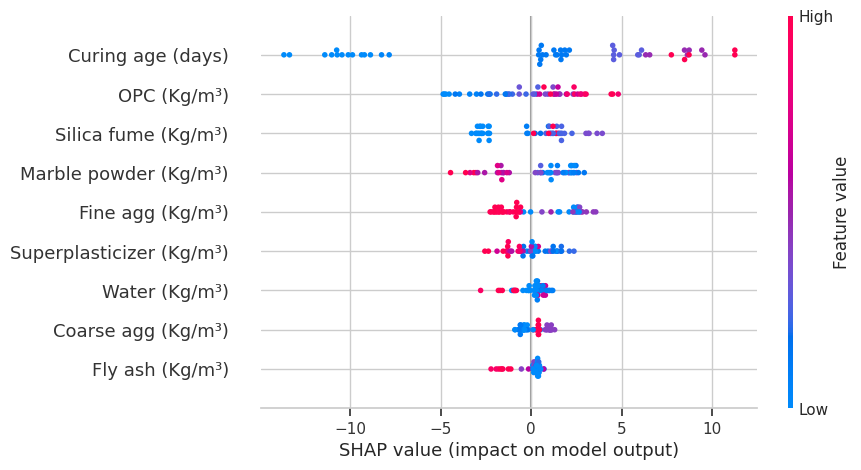

<Figure size 640x480 with 0 Axes>

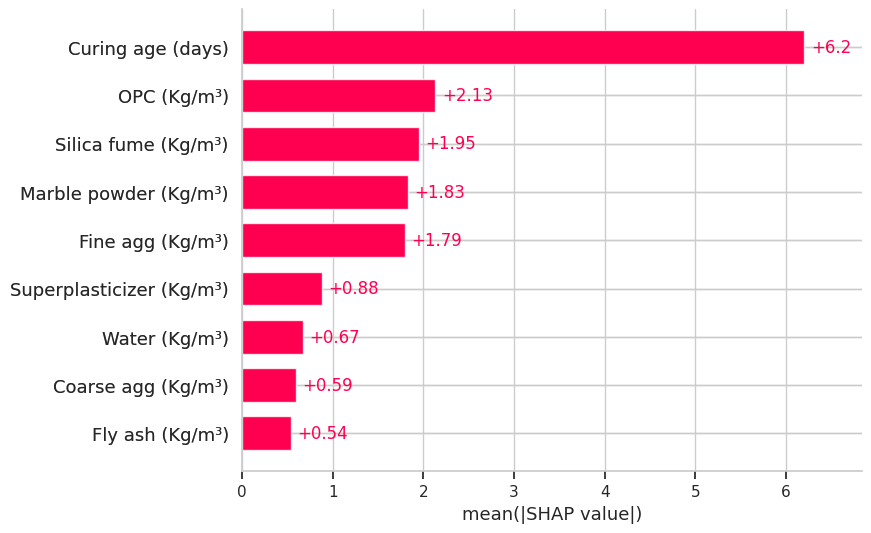

<Figure size 640x480 with 0 Axes>

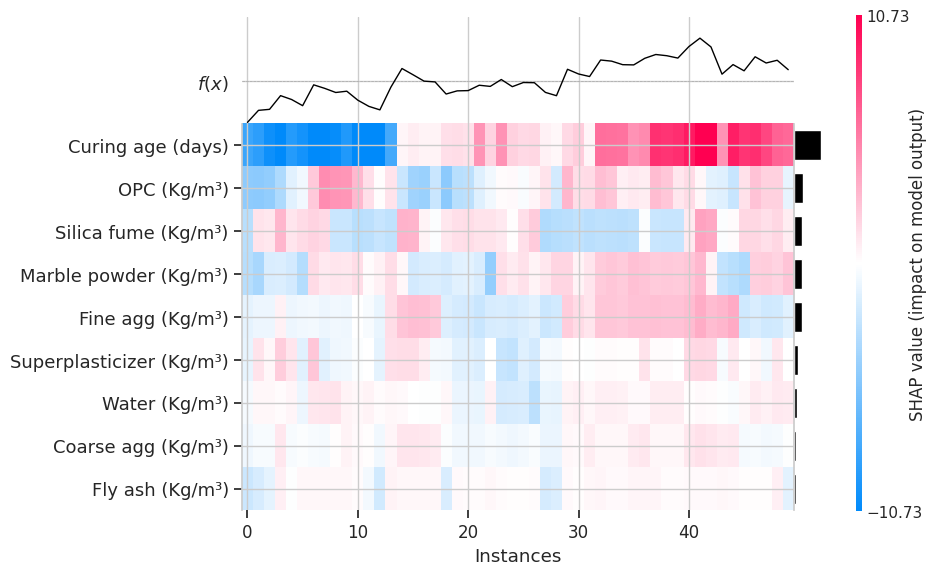

<Figure size 640x480 with 0 Axes>

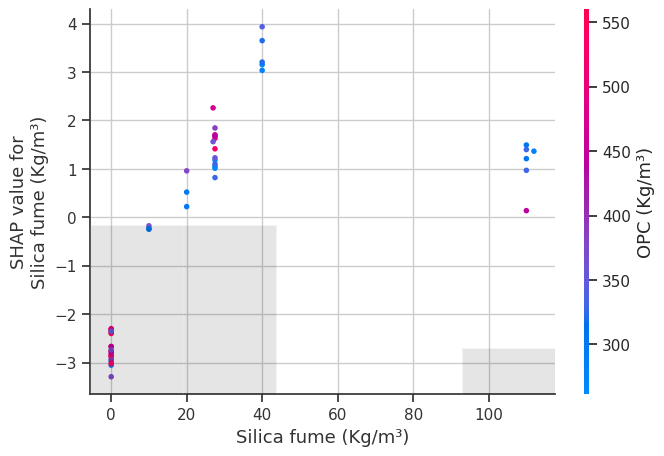

<Figure size 640x480 with 0 Axes>

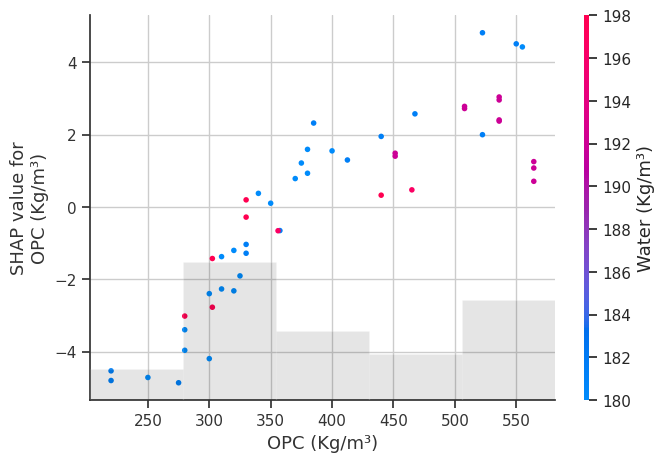

<Figure size 640x480 with 0 Axes>

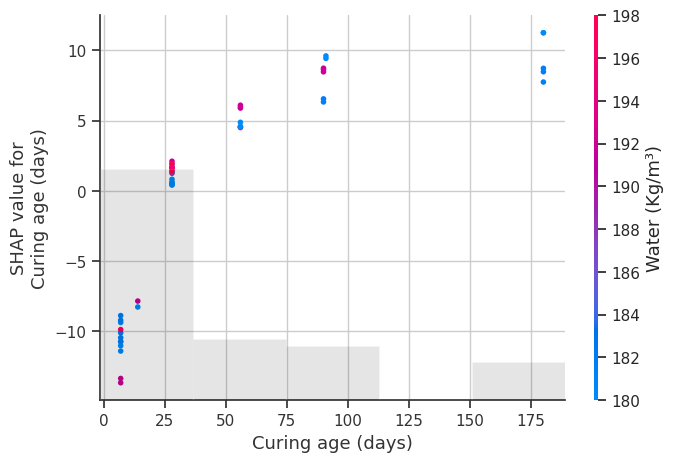

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models

modelname = "Gradient Boosting"

explainer = shap.Explainer(results[modelname]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()


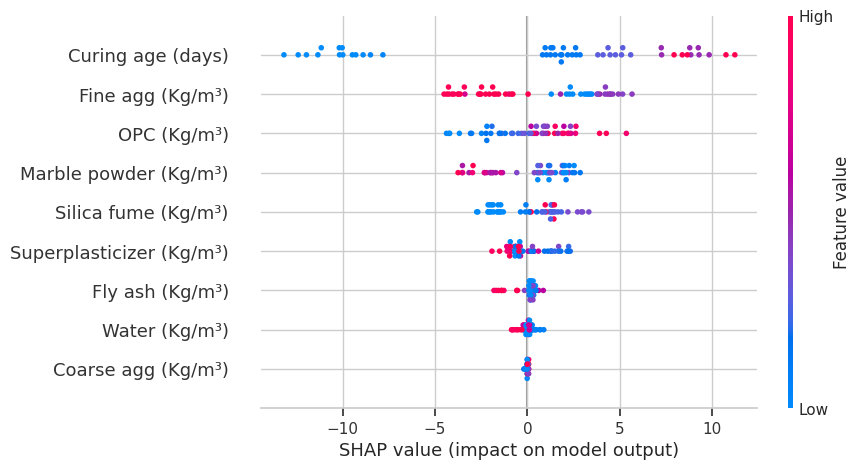

<Figure size 640x480 with 0 Axes>

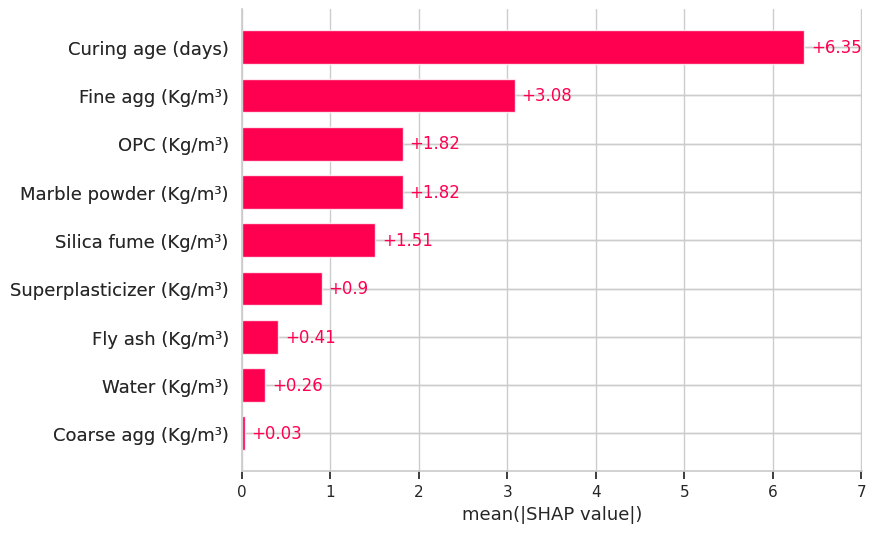

<Figure size 640x480 with 0 Axes>

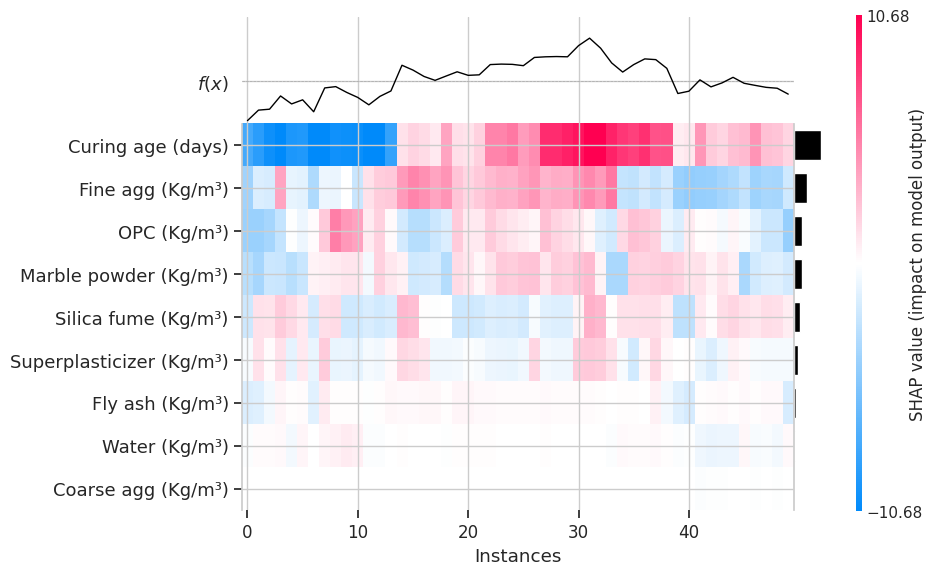

<Figure size 640x480 with 0 Axes>

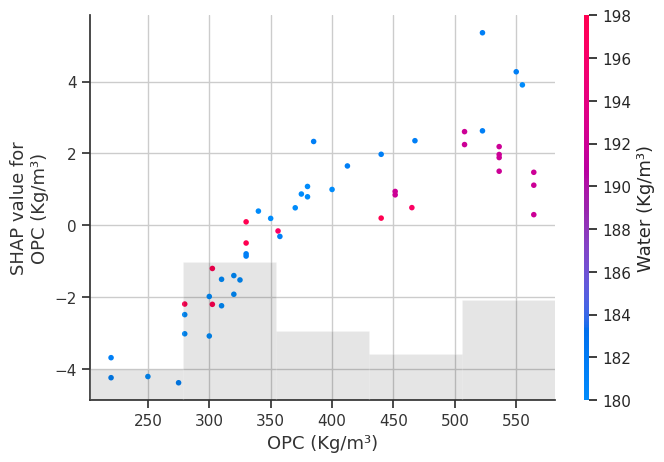

<Figure size 640x480 with 0 Axes>

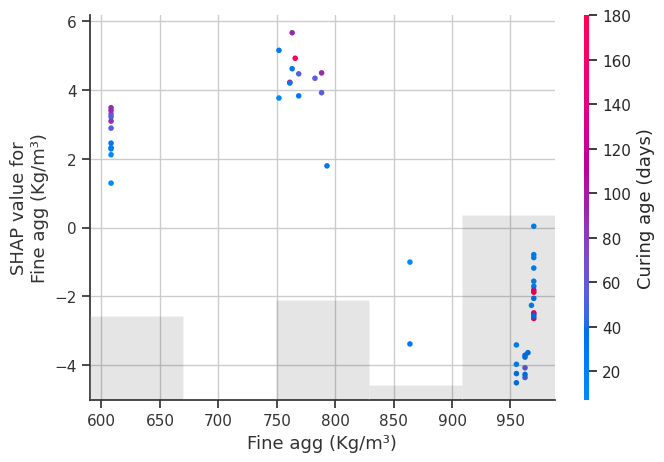

<Figure size 640x480 with 0 Axes>

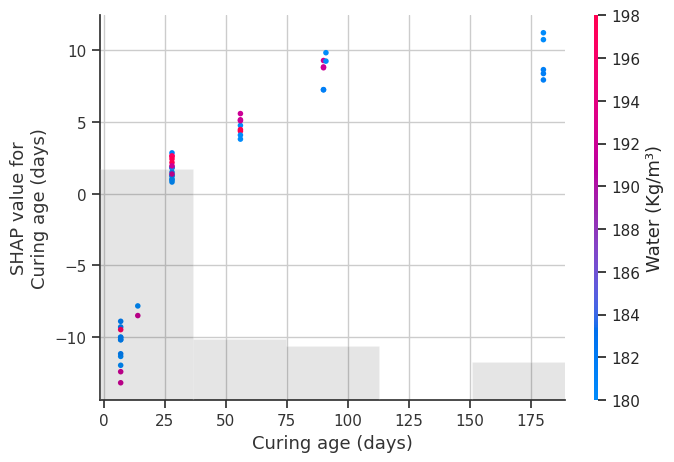

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models


explainer = shap.Explainer(results["XGBoost"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

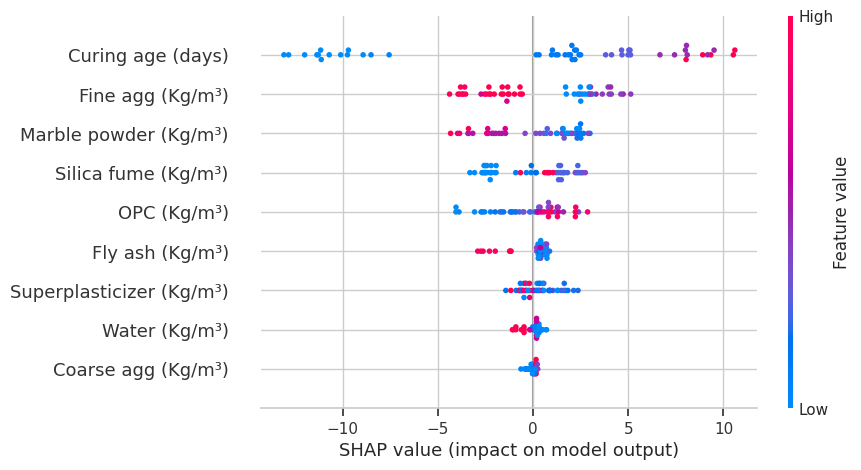

<Figure size 640x480 with 0 Axes>

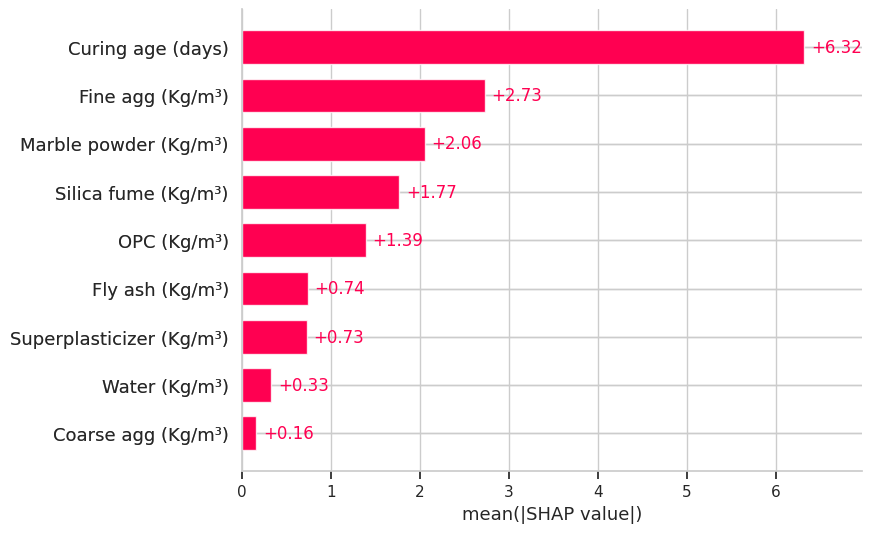

<Figure size 640x480 with 0 Axes>

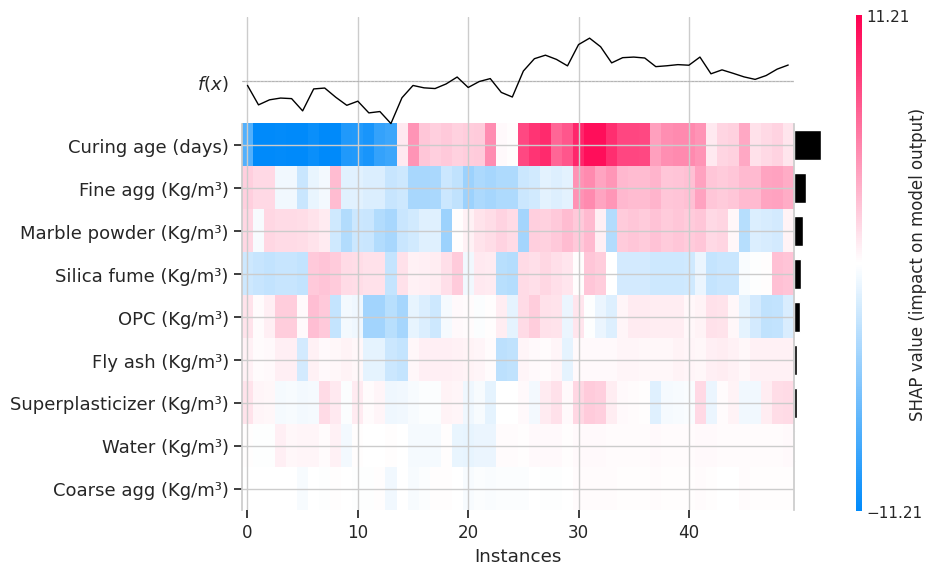

<Figure size 640x480 with 0 Axes>

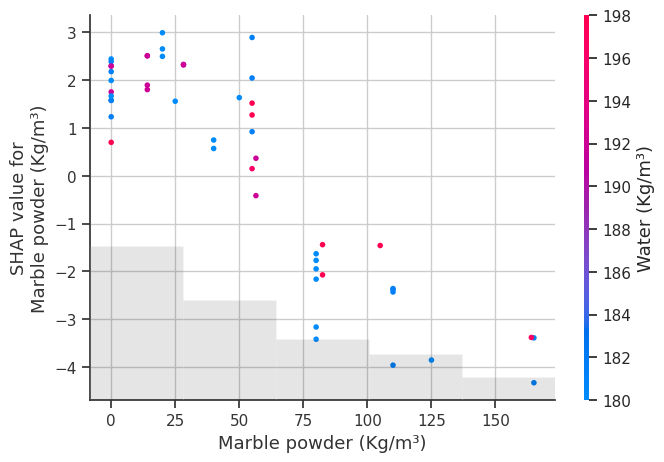

<Figure size 640x480 with 0 Axes>

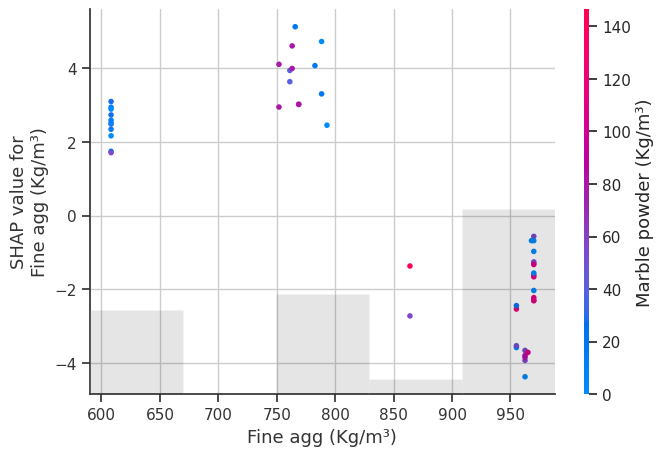

<Figure size 640x480 with 0 Axes>

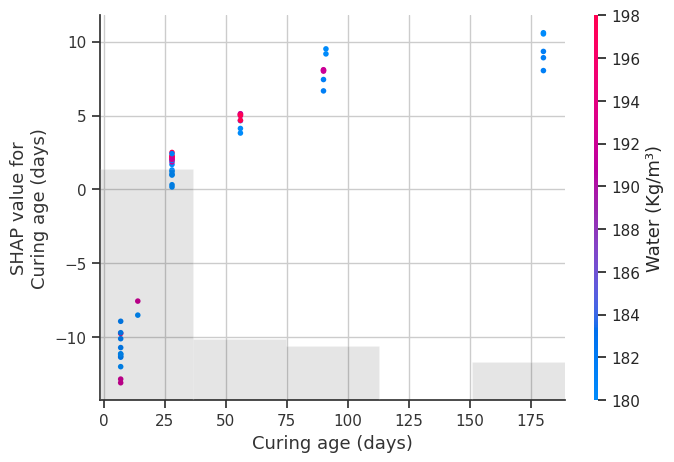

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models


explainer = shap.Explainer(results["LightGBM"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

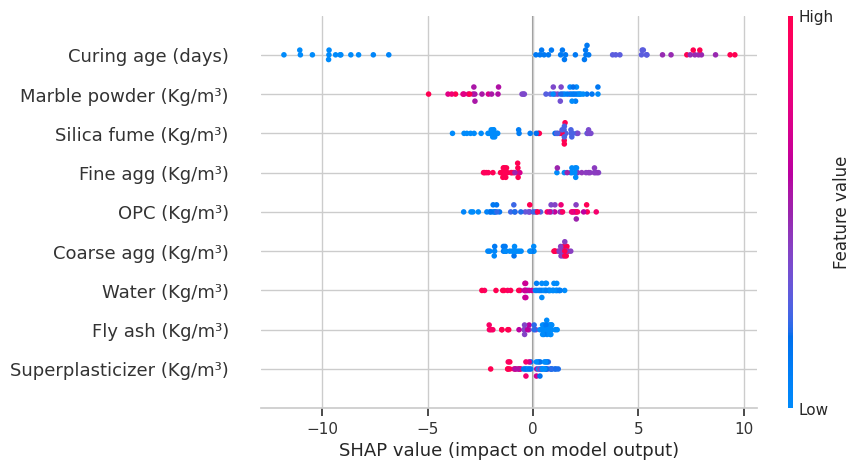

<Figure size 640x480 with 0 Axes>

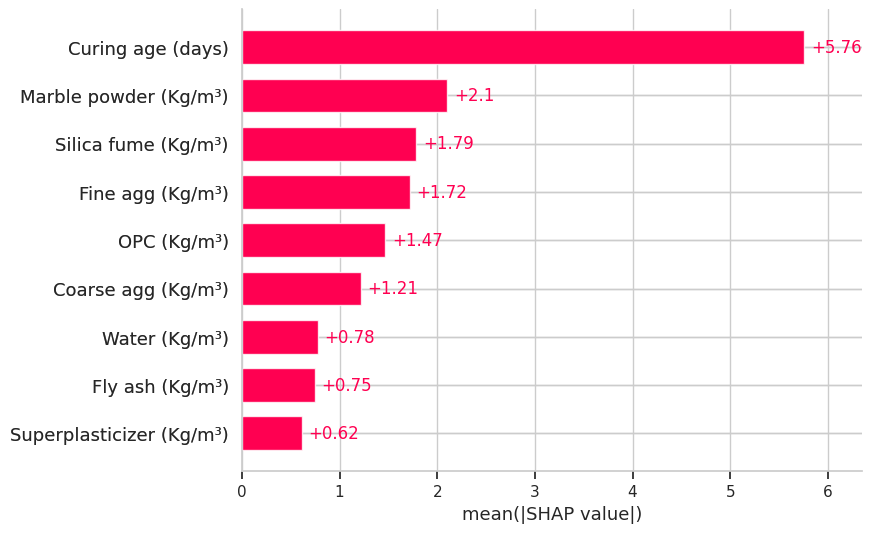

<Figure size 640x480 with 0 Axes>

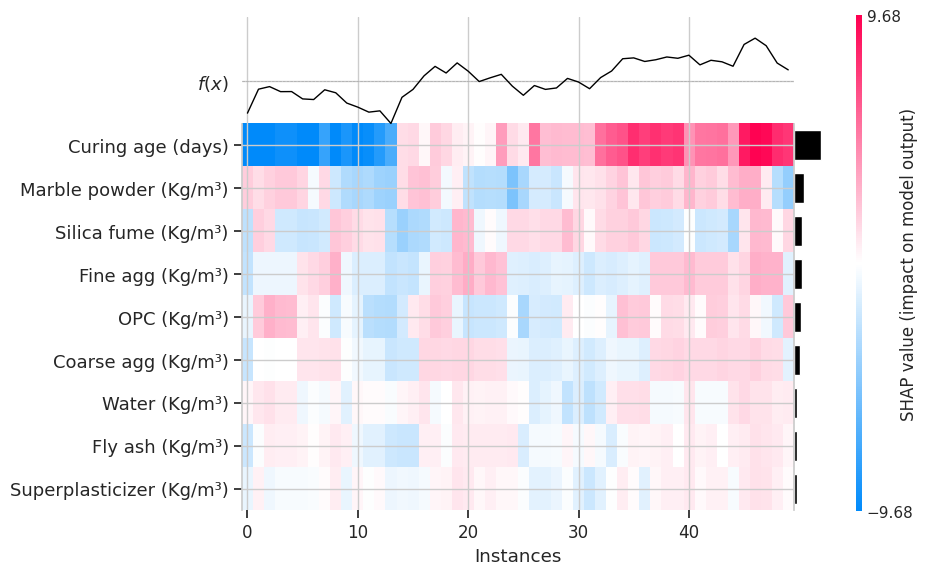

<Figure size 640x480 with 0 Axes>

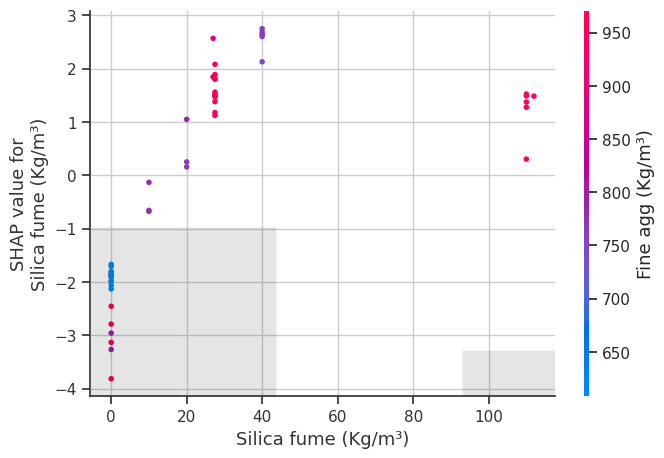

<Figure size 640x480 with 0 Axes>

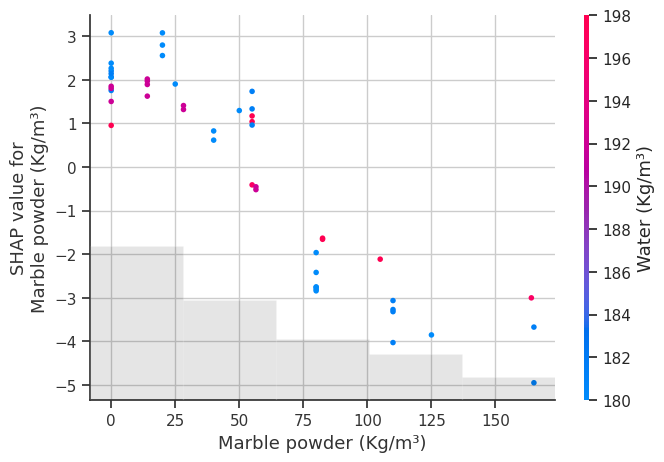

<Figure size 640x480 with 0 Axes>

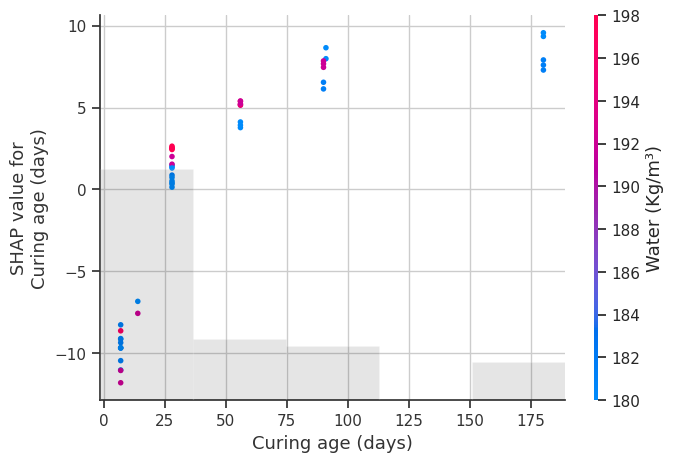

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use TreeExplainer for tree-based models


explainer = shap.Explainer(results["CatBoost"]["Best Model"])
shap_values = explainer(X_test)

# 1. SHAP Summary Plot
shap.plots.beeswarm(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 2. SHAP Bar plot (mean absolute SHAP values)
shap.plots.bar(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 3. SHAP Heatmap
shap.plots.heatmap(shap_values)
plt.subplots_adjust(hspace=0.5)  # Add vertical gap
plt.tight_layout()
plt.show()

# 4. SHAP Dependence Plot (for top 3 features)
top_features = np.argsort(np.abs(shap_values.values).mean(0))[-3:]
for i in top_features:
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.subplots_adjust(hspace=0.5)  # Add vertical gap
    plt.tight_layout()
    plt.show()

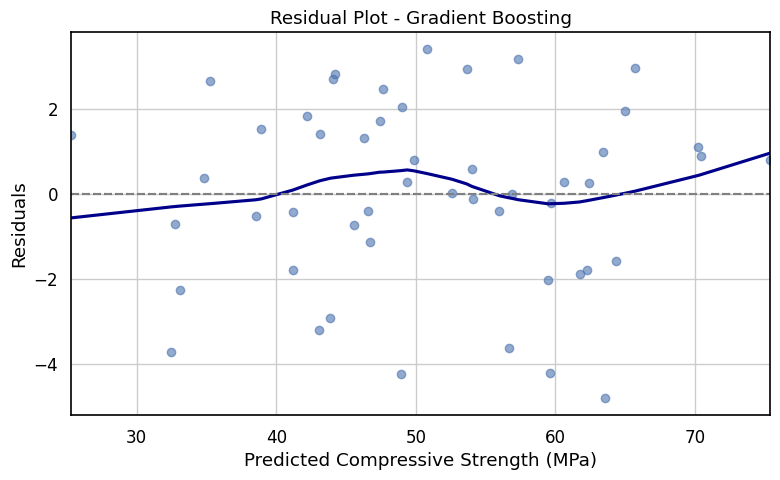

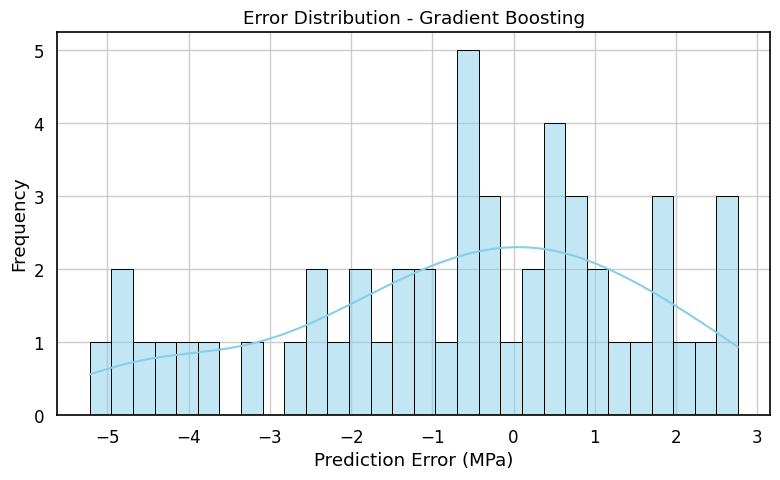

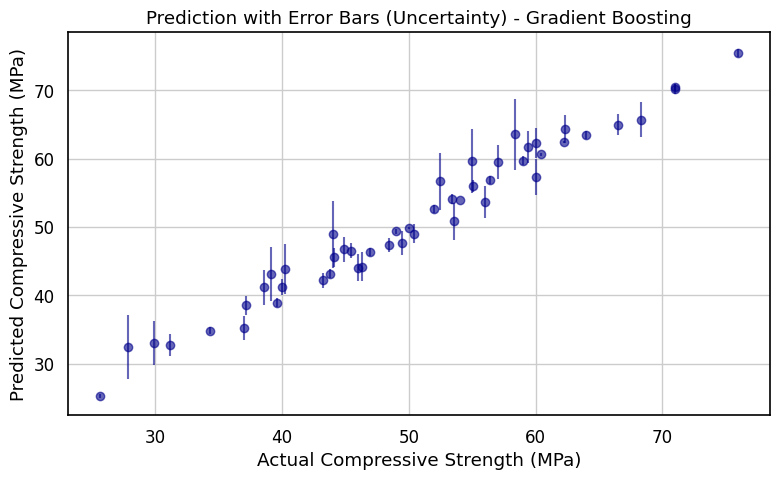

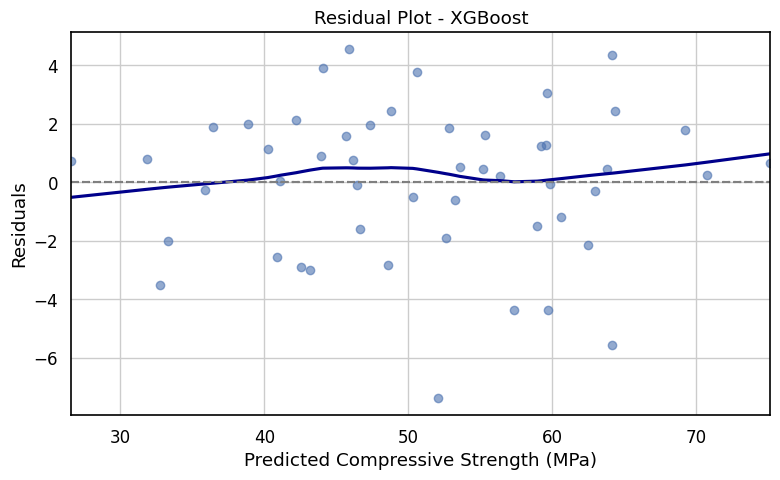

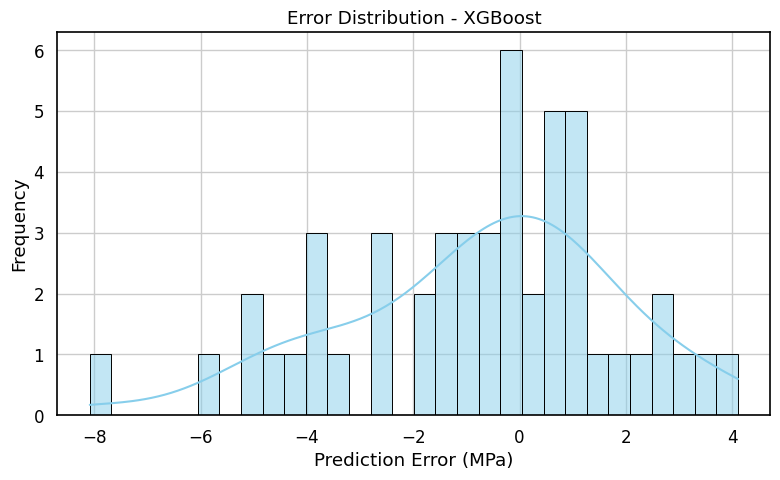

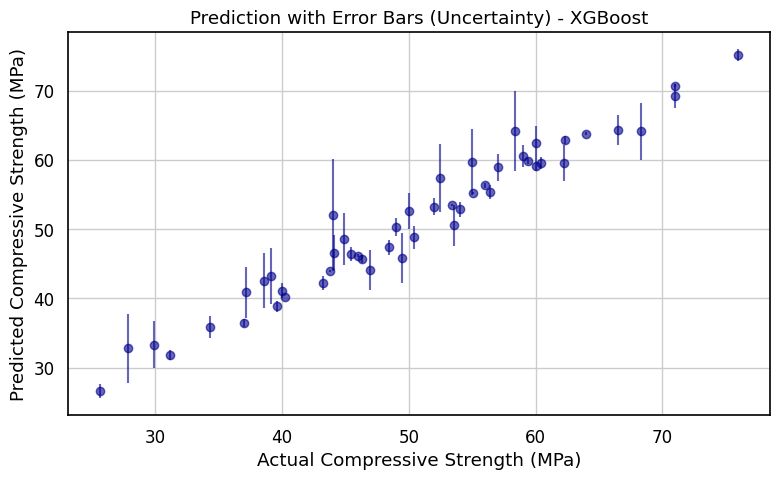

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


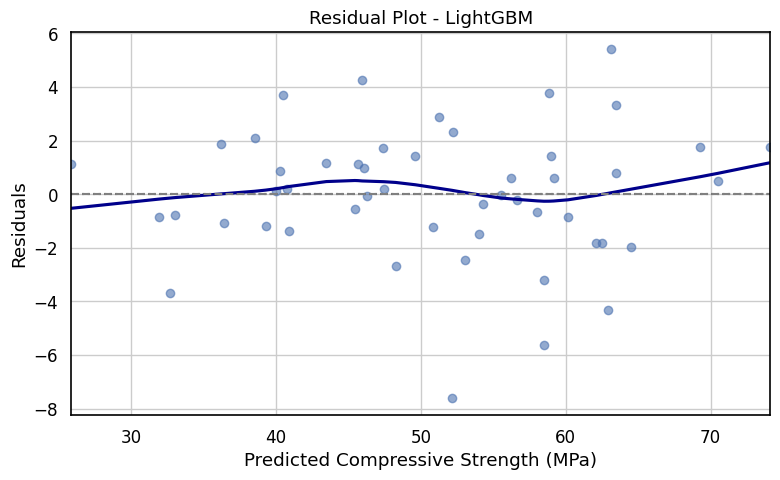

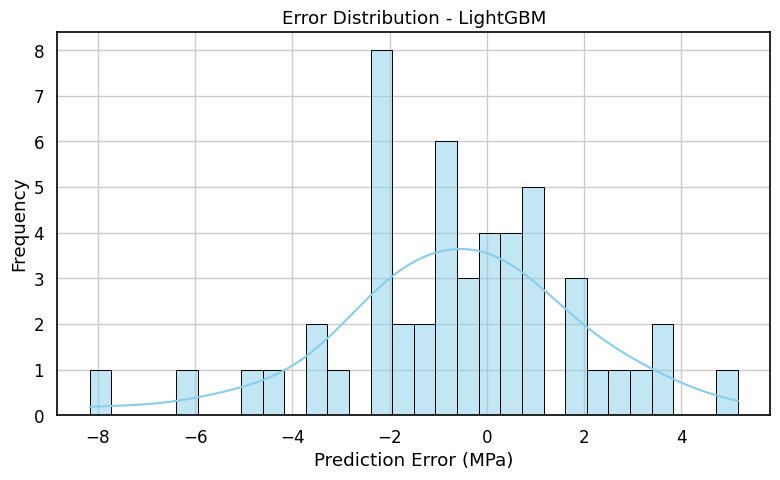

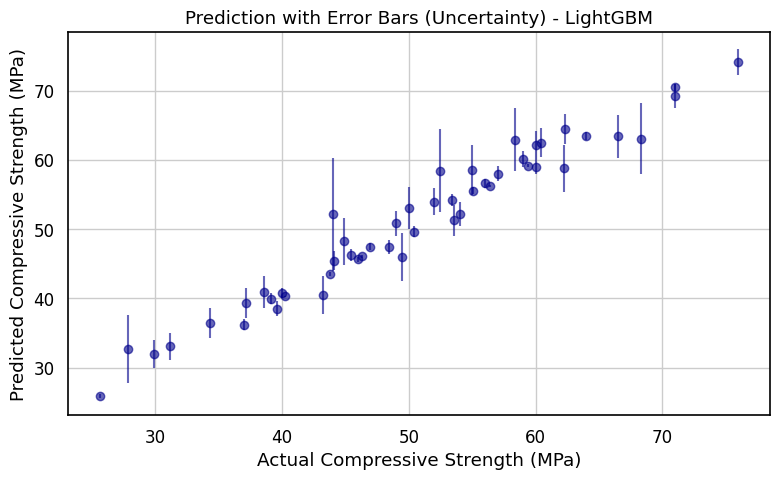

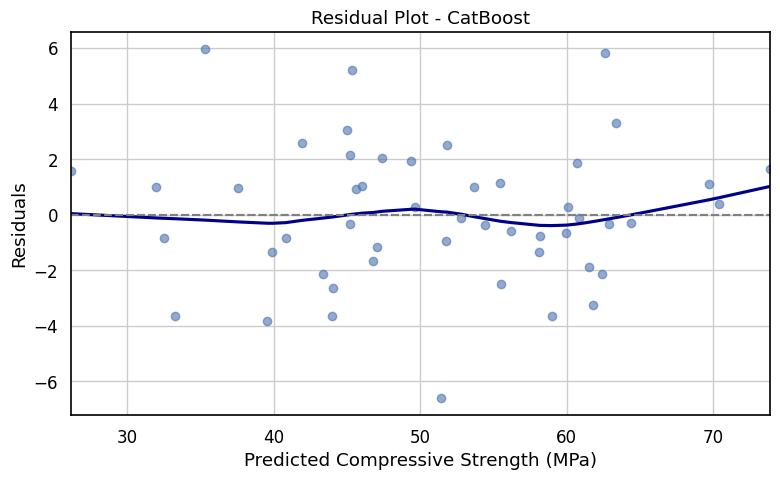

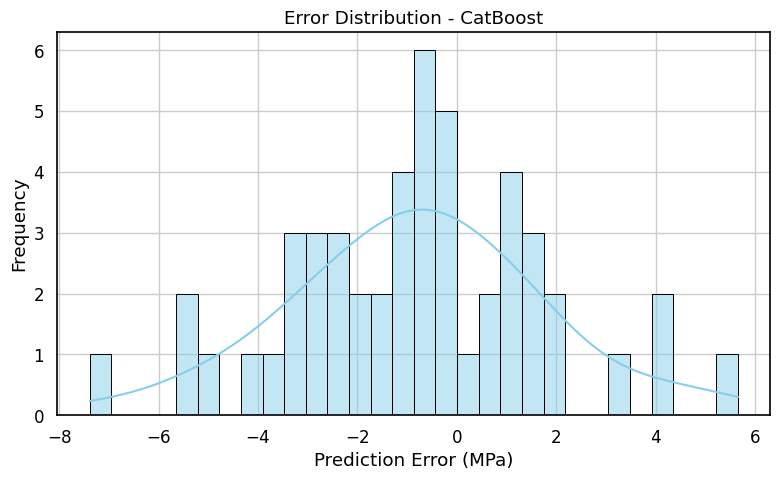

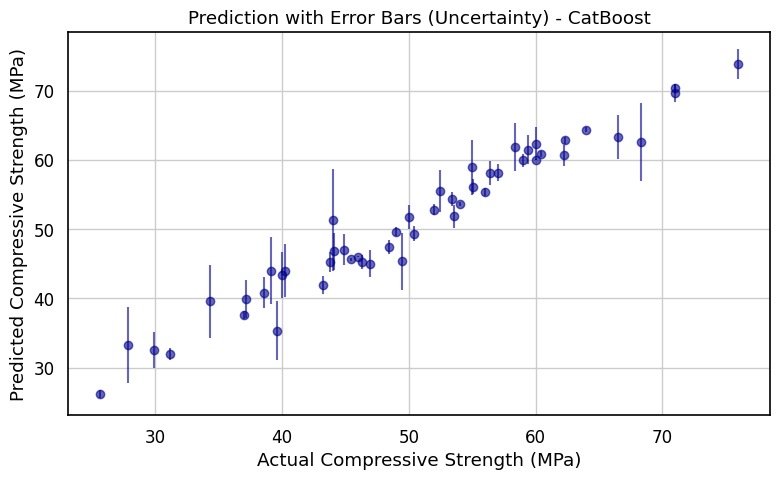

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Iterate over each model and generate residual/error plots
for model_name, result in results.items():
    best_model = result["Best Model"]

    # For Hybrid model, special prediction path
    if model_name == "Hybrid XGB-LGB":
        xgb_preds_test = results["XGBoost"]["Best Model"].predict(X_test).reshape(-1, 1)
        y_pred = best_model.predict(xgb_preds_test)
    else:
        y_pred = best_model.predict(X_test)

    residuals = y_test - y_pred
    errors = residuals

    # 1. Residual Plot with LOWESS
    plt.figure(figsize=(8, 5))
    ax1 = sns.residplot(x=y_pred, y=residuals, lowess=True,
                        scatter_kws={'alpha': 0.6}, line_kws={'color': 'darkblue'})
    plt.axhline(y=0, color='gray', linestyle='--')
    ax1.set_title(f"Residual Plot - {model_name}", color='black')
    ax1.set_xlabel("Predicted Compressive Strength (MPa)", color='black')
    ax1.set_ylabel("Residuals", color='black')
    ax1.tick_params(colors='black')
    ax1.grid(True)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

    # 2. Error Distribution Histogram
    plt.figure(figsize=(8, 5))
    ax2 = sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor='black', linewidth=0.7)
    ax2.set_title(f"Error Distribution - {model_name}", color='black')
    ax2.set_xlabel("Prediction Error (MPa)", color='black')
    ax2.set_ylabel("Frequency", color='black')
    ax2.tick_params(colors='black')
    ax2.grid(True)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

    # 3. Prediction with Error Bars (Uncertainty)
    fig, ax3 = plt.subplots(figsize=(8, 5))
    ax3.errorbar(y_test, y_pred, yerr=np.abs(errors), fmt='o', alpha=0.6, color='darkblue')
    ax3.set_title(f"Prediction with Error Bars (Uncertainty) - {model_name}", color='black')
    ax3.set_xlabel("Actual Compressive Strength (MPa)", color='black')
    ax3.set_ylabel("Predicted Compressive Strength (MPa)", color='black')
    ax3.tick_params(colors='black')
    ax3.grid(True)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from matplotlib.backends.backend_pdf import PdfPages
# from google.colab import files

# # Output filename
# pdf_filename = "residual_error_plots.pdf"

# # Create PDF to store all plots
# with PdfPages(pdf_filename) as pdf:
#     for model_name, result in results.items():
#         best_model = result["Best Model"]

#         if model_name == "Hybrid XGB-LGB":
#             xgb_preds_test = results["XGBoost"]["Best Model"].predict(X_test).reshape(-1, 1)
#             y_pred = best_model.predict(xgb_preds_test)
#         else:
#             y_pred = best_model.predict(X_test)

#         residuals = y_test - y_pred
#         errors = residuals

#         # 1. Residual Plot with LOWESS
#         fig1 = plt.figure(figsize=(8, 5))
#         ax1 = sns.residplot(x=y_pred, y=residuals, lowess=True,
#                             scatter_kws={'alpha': 0.6}, line_kws={'color': 'darkblue'})
#         plt.axhline(y=0, color='gray', linestyle='--')
#         ax1.set_title(f"Residual Plot - {model_name}", color='black')
#         ax1.set_xlabel("Predicted Compressive Strength (MPa)", color='black')
#         ax1.set_ylabel("Residuals", color='black')
#         ax1.tick_params(colors='black')
#         ax1.grid(True)
#         for spine in ax1.spines.values():
#             spine.set_edgecolor('black')
#             spine.set_linewidth(1.2)
#         plt.tight_layout()
#         pdf.savefig(fig1)
#         plt.close()

#         # 2. Error Distribution Histogram
#         fig2 = plt.figure(figsize=(8, 5))
#         ax2 = sns.histplot(residuals, bins=30, kde=True, color="skyblue", edgecolor='black', linewidth=0.7)
#         ax2.set_title(f"Error Distribution - {model_name}", color='black')
#         ax2.set_xlabel("Prediction Error (MPa)", color='black')
#         ax2.set_ylabel("Frequency", color='black')
#         ax2.tick_params(colors='black')
#         ax2.grid(True)
#         for spine in ax2.spines.values():
#             spine.set_edgecolor('black')
#             spine.set_linewidth(1.2)
#         plt.tight_layout()
#         pdf.savefig(fig2)
#         plt.close()

#         # 3. Prediction with Error Bars
#         fig3, ax3 = plt.subplots(figsize=(8, 5))
#         ax3.errorbar(y_test, y_pred, yerr=np.abs(errors), fmt='o', alpha=0.6, color='darkblue')
#         ax3.set_title(f"Prediction with Error Bars (Uncertainty) - {model_name}", color='black')
#         ax3.set_xlabel("Actual Compressive Strength (MPa)", color='black')
#         ax3.set_ylabel("Predicted Compressive Strength (MPa)", color='black')
#         ax3.tick_params(colors='black')
#         ax3.grid(True)
#         for spine in ax3.spines.values():
#             spine.set_edgecolor('black')
#             spine.set_linewidth(1.2)
#         plt.tight_layout()
#         pdf.savefig(fig3)
#         plt.close()

#         print(f"Saved all 3 plots for: {model_name}")

# # Download the PDF
# files.download(pdf_filename)


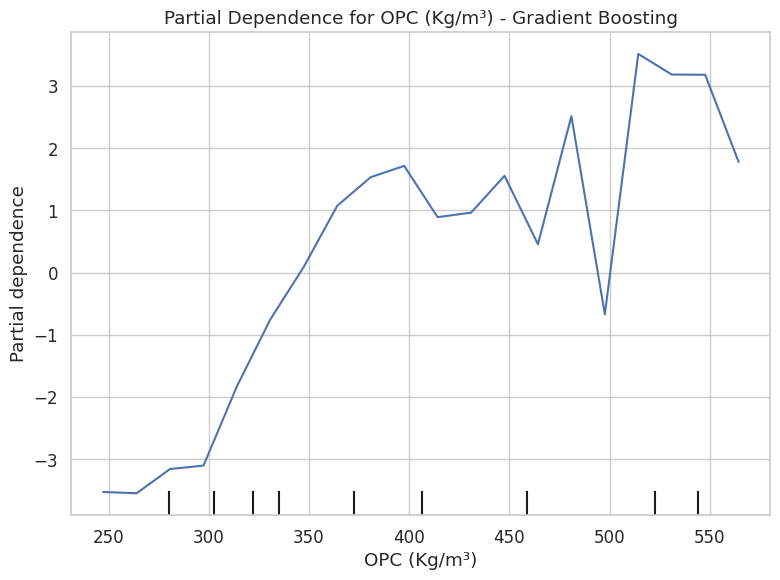

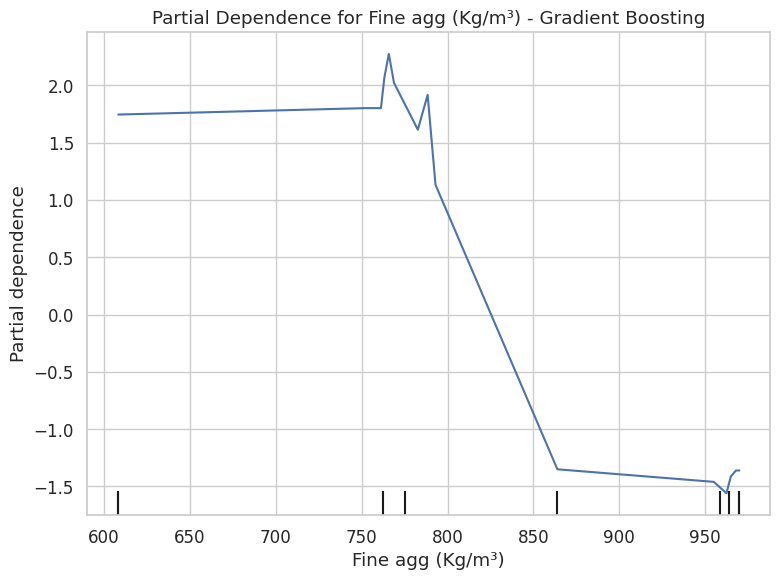

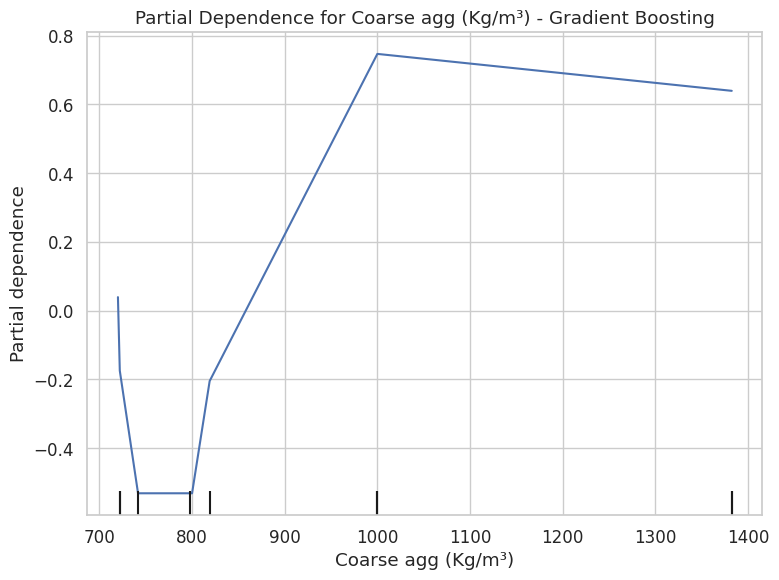

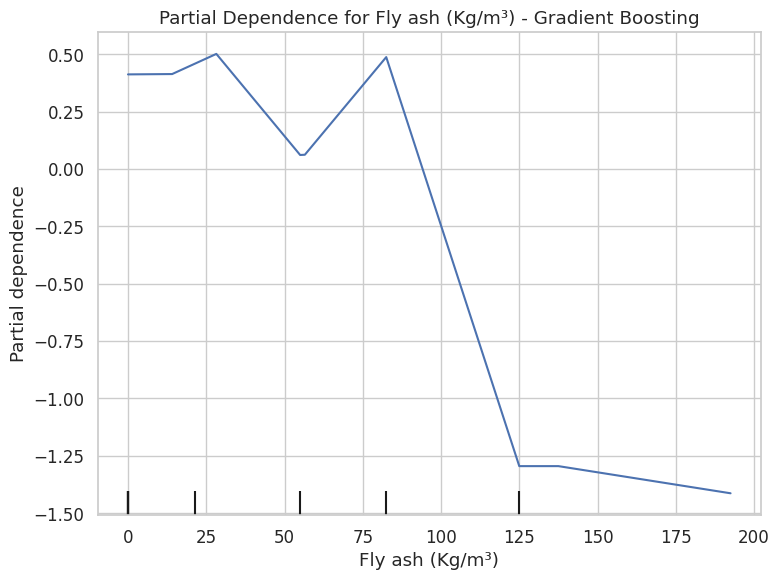

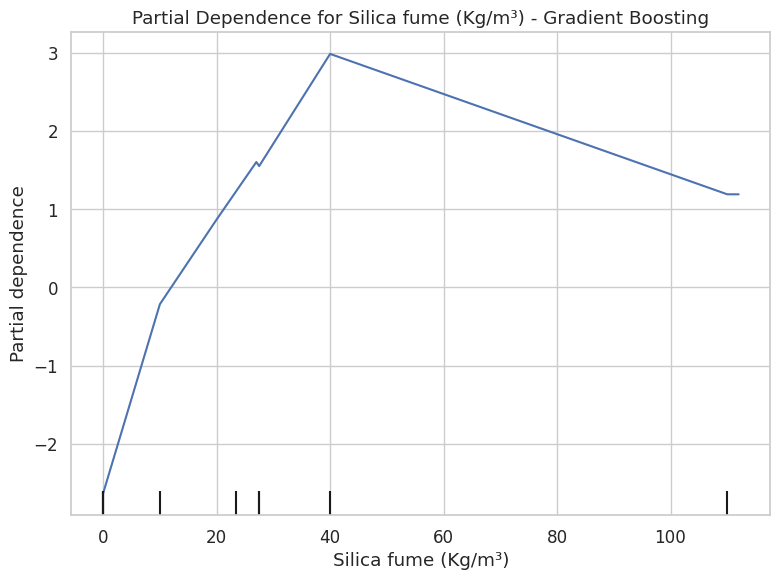

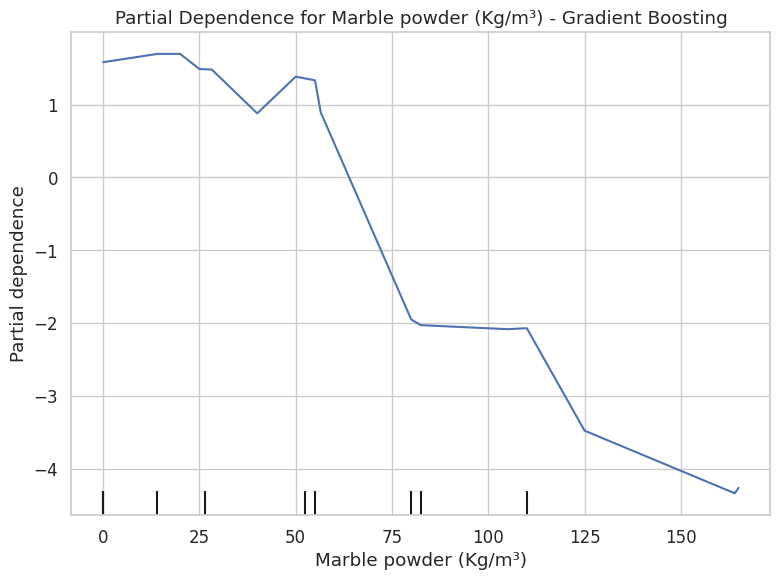

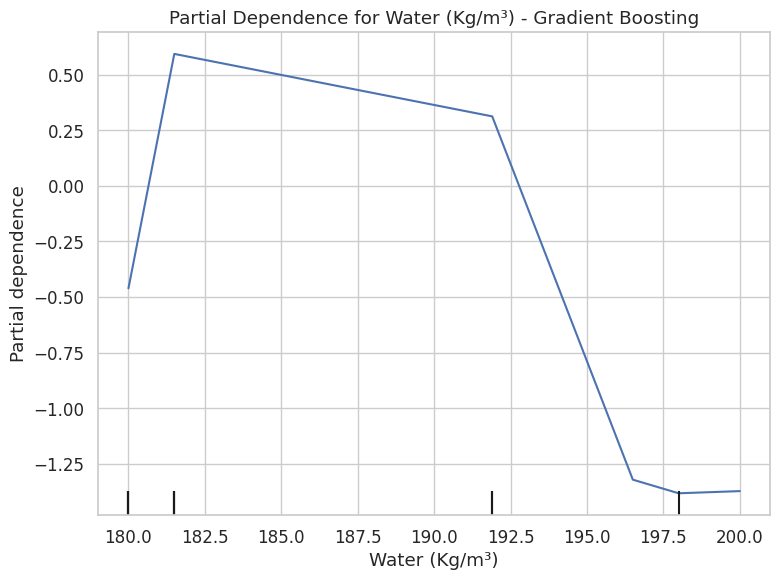

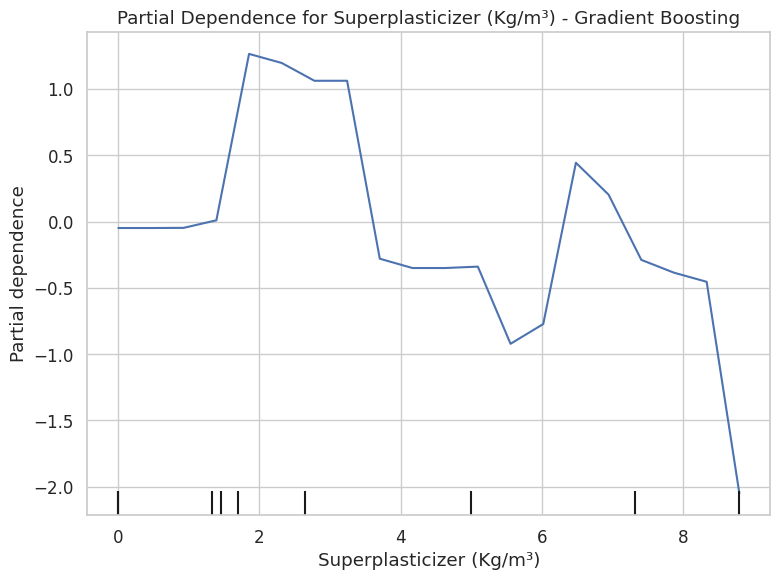

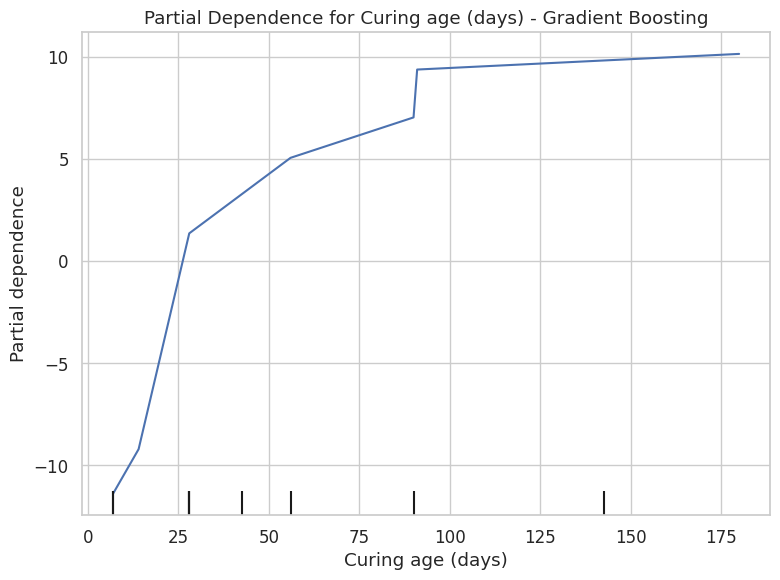

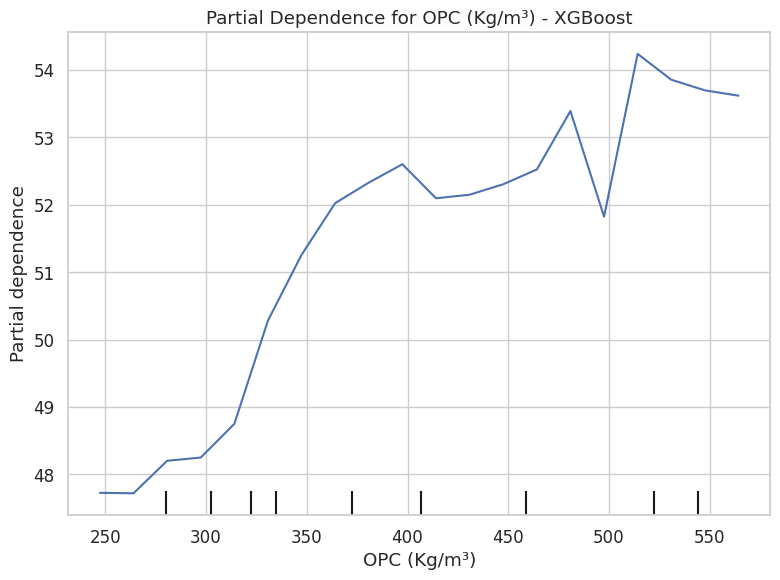

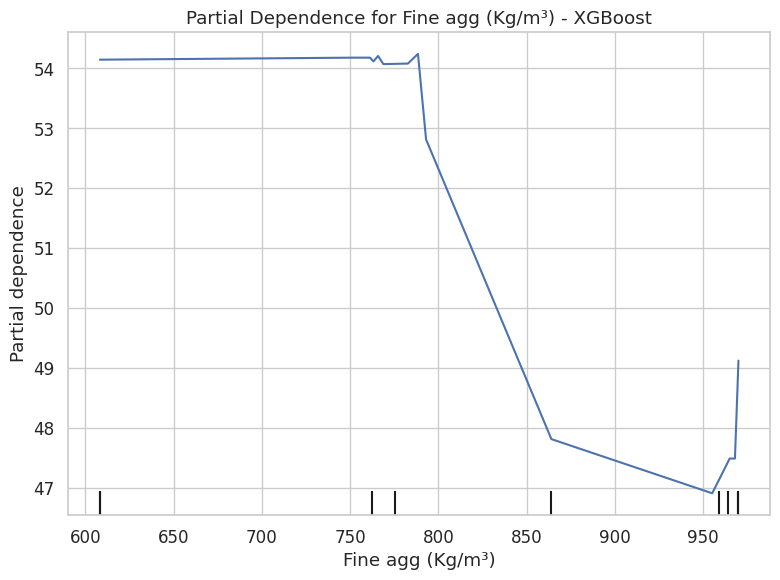

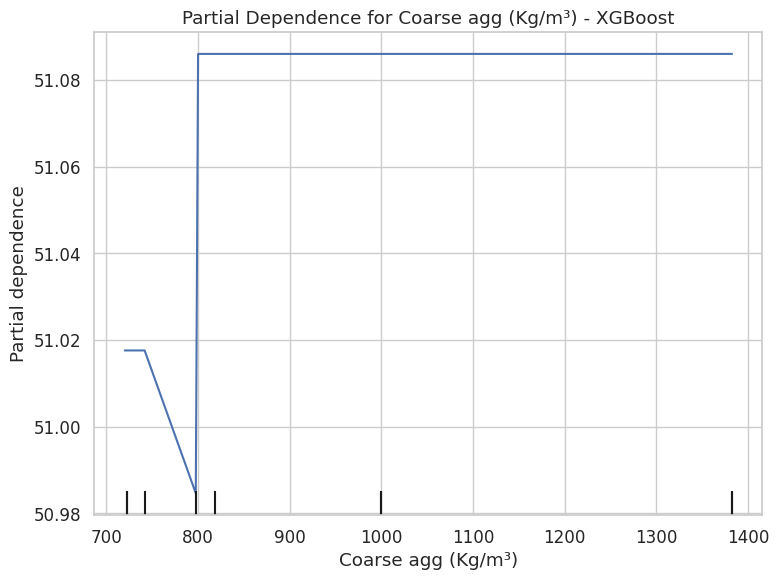

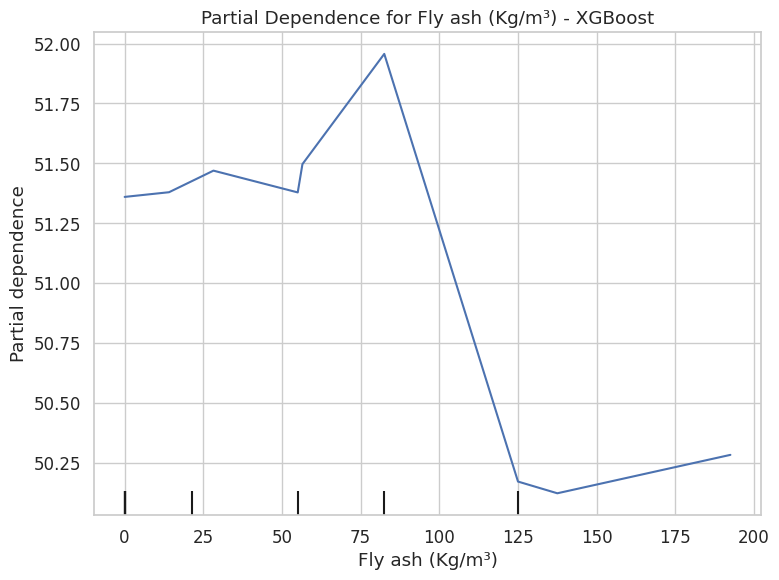

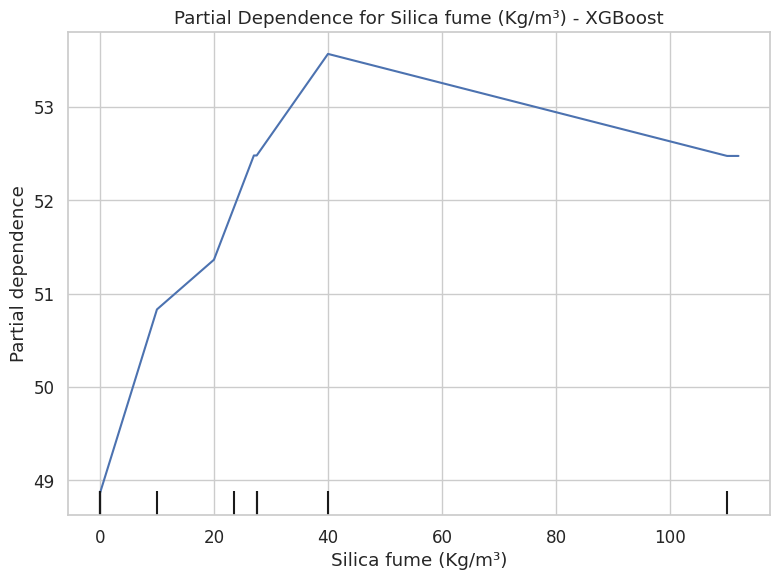

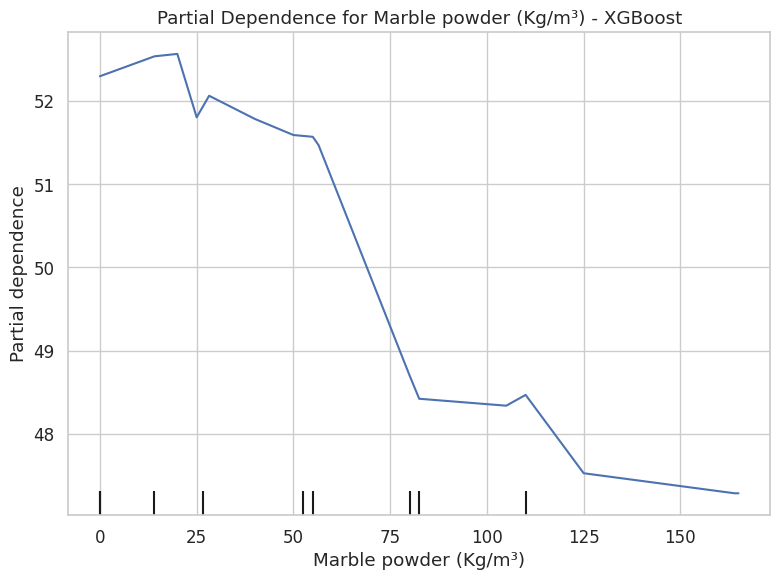

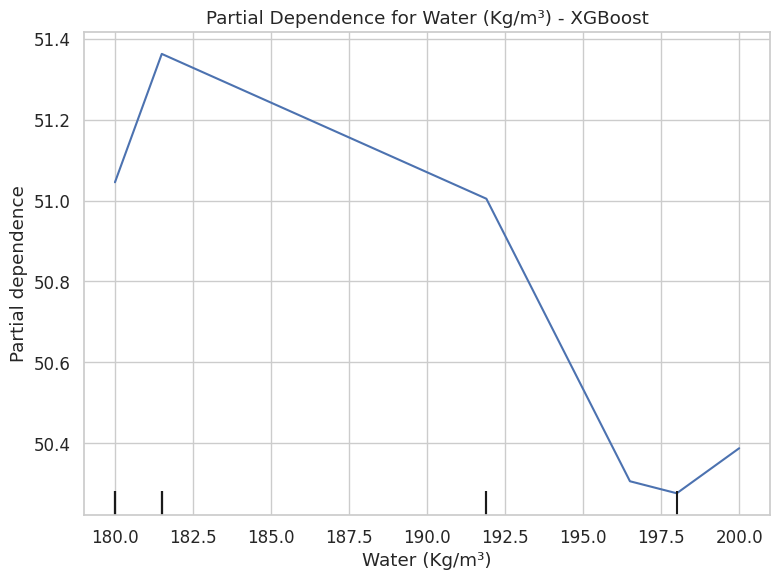

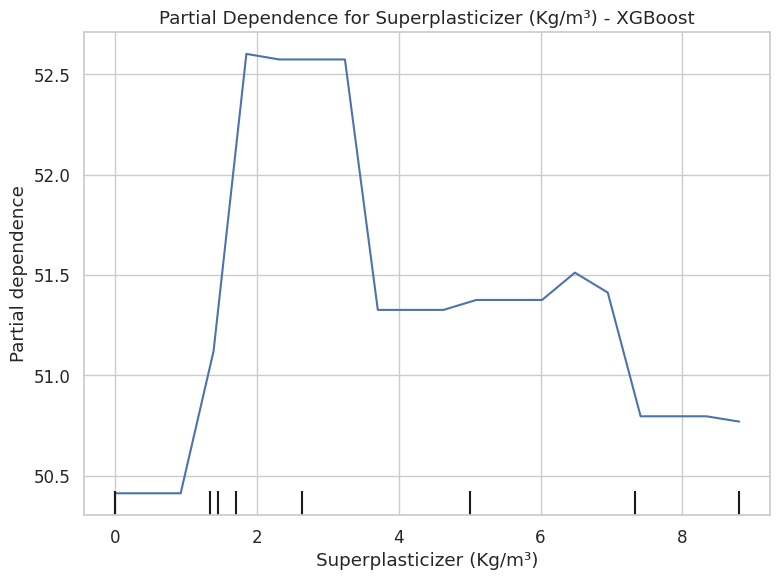

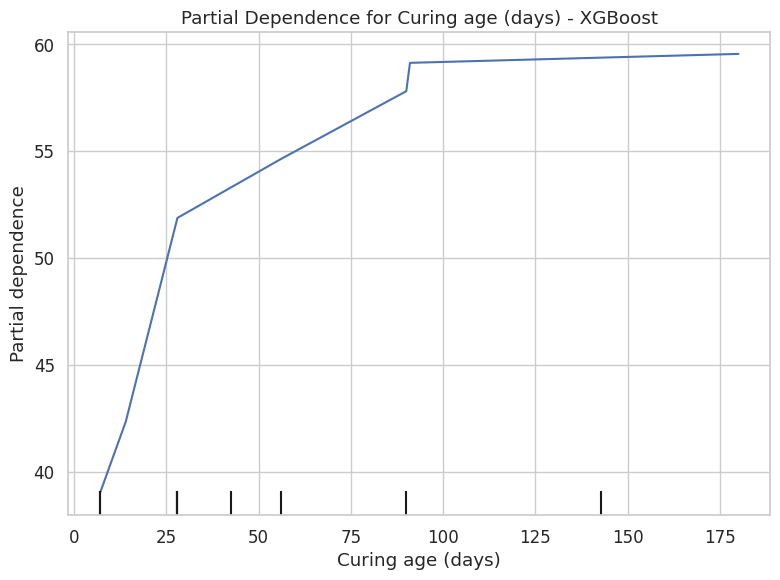



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

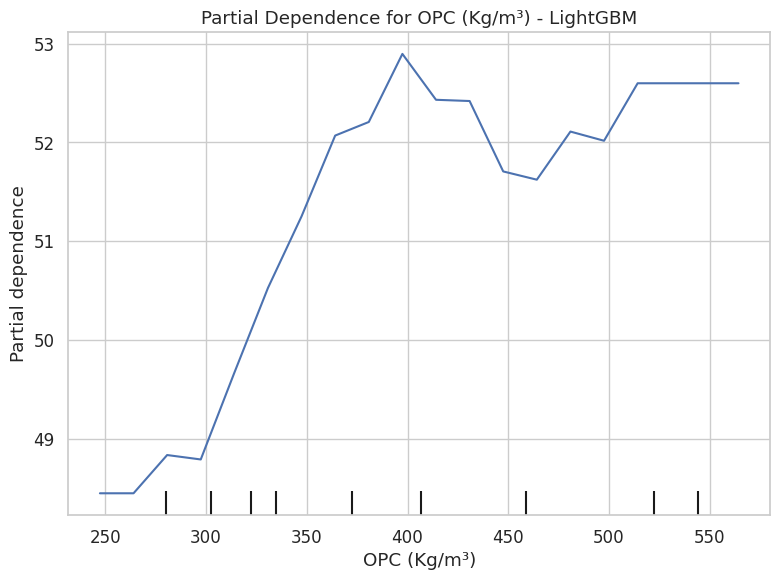



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

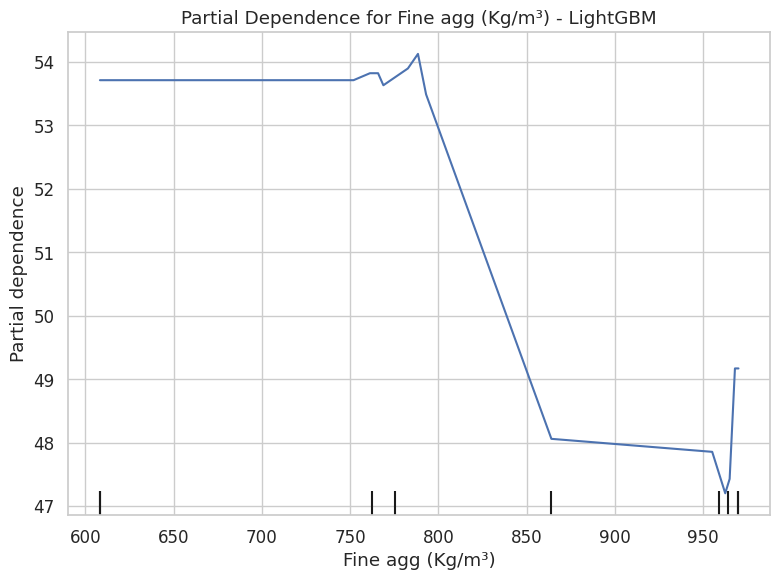



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


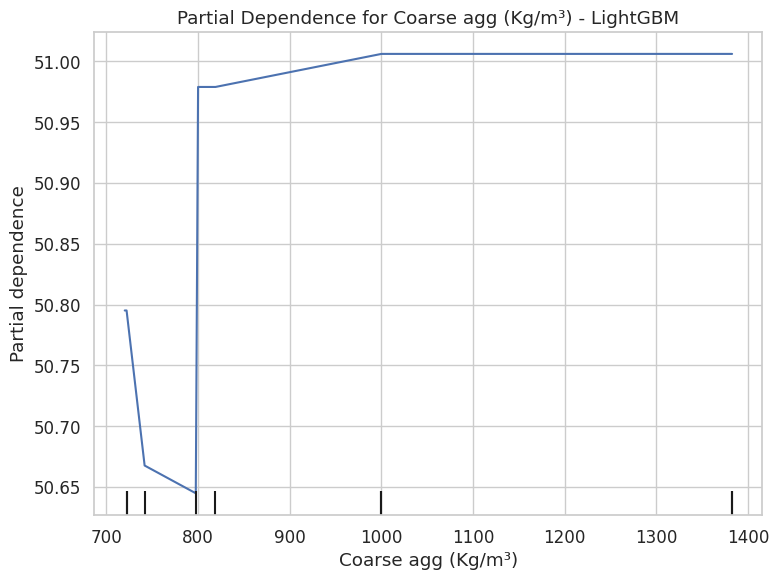



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

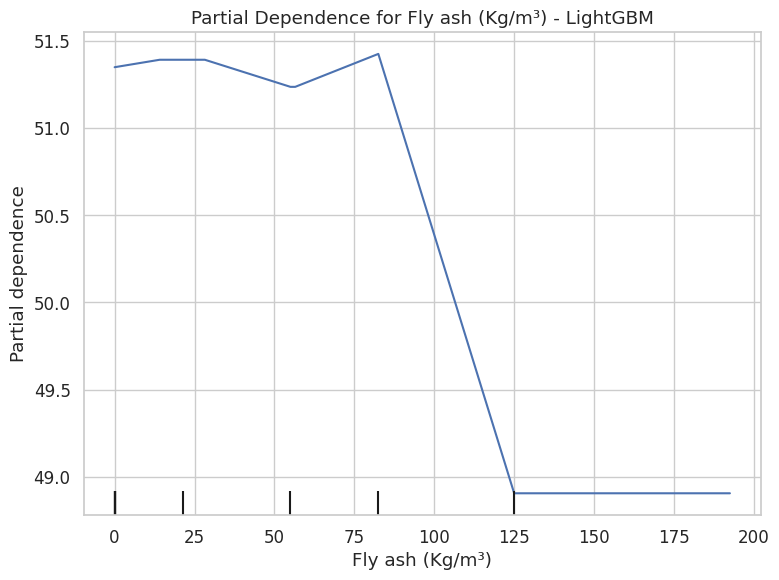



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


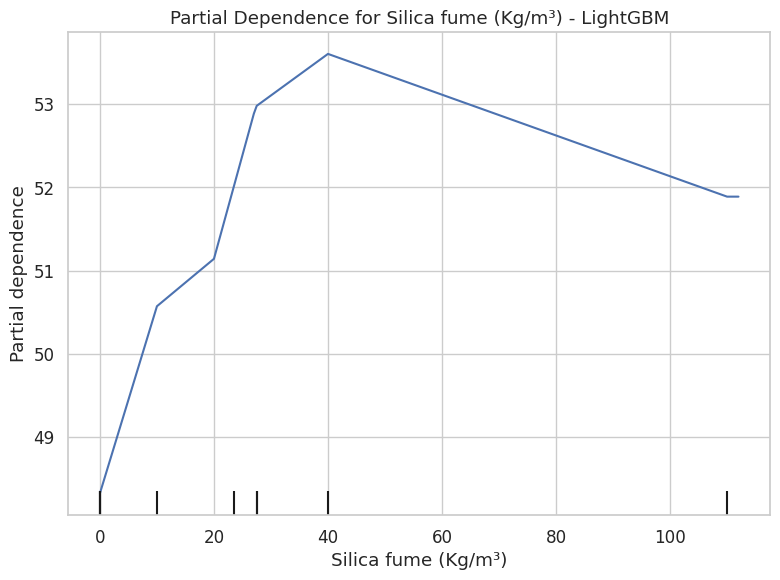



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

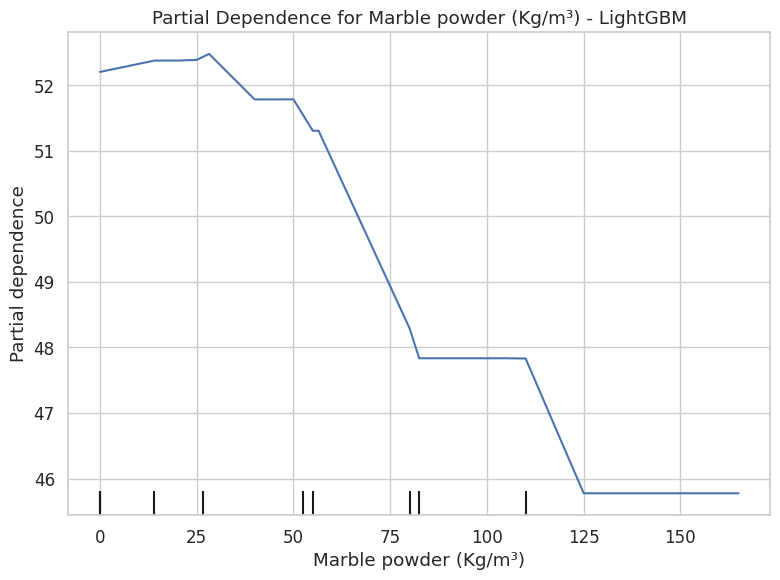



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


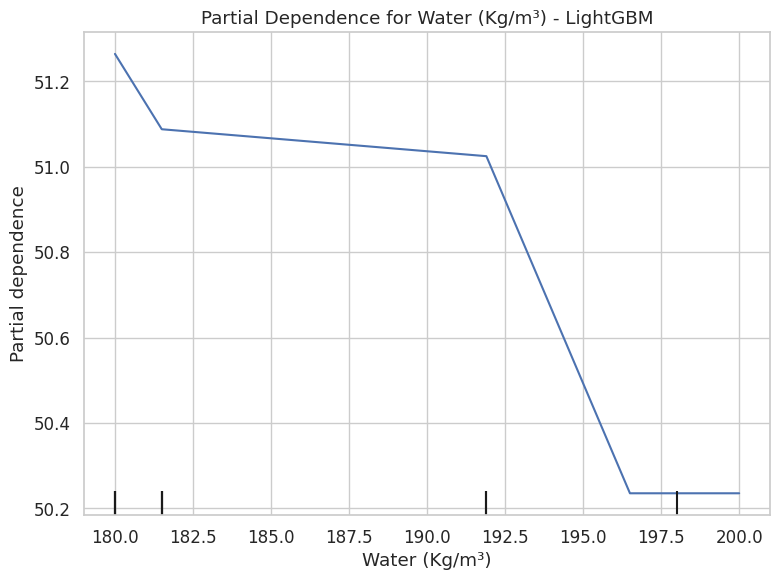



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] m

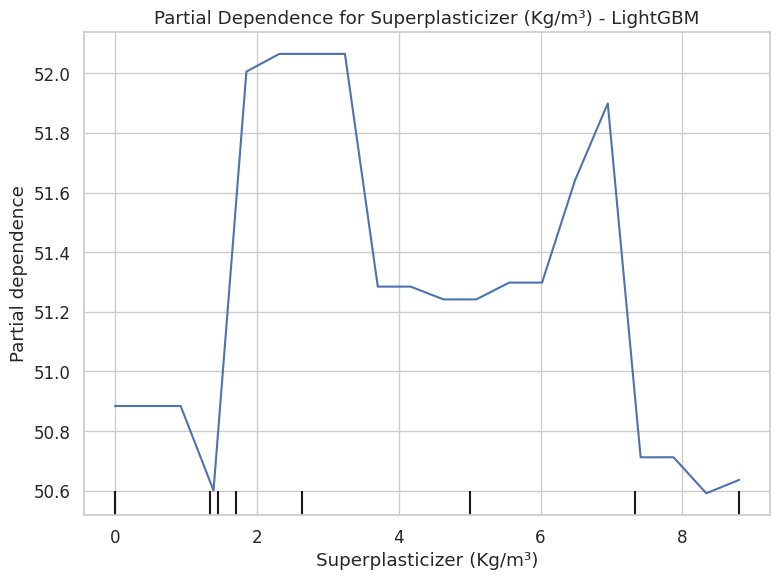



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


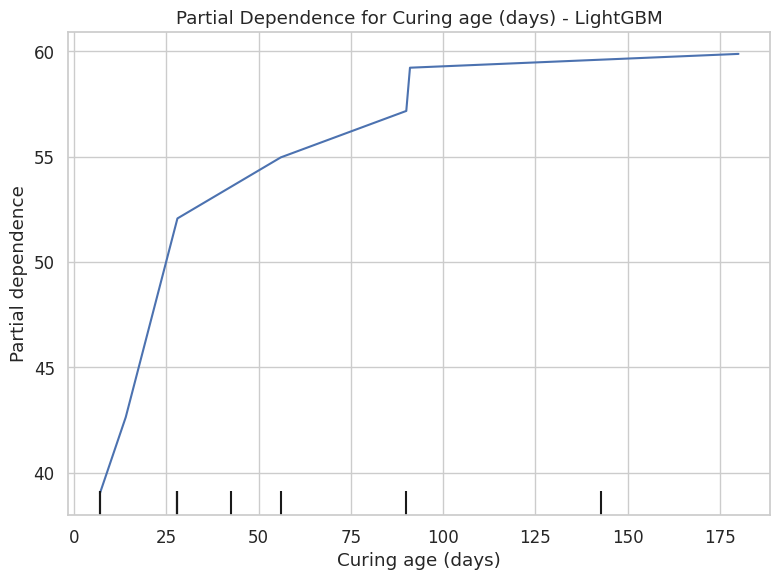

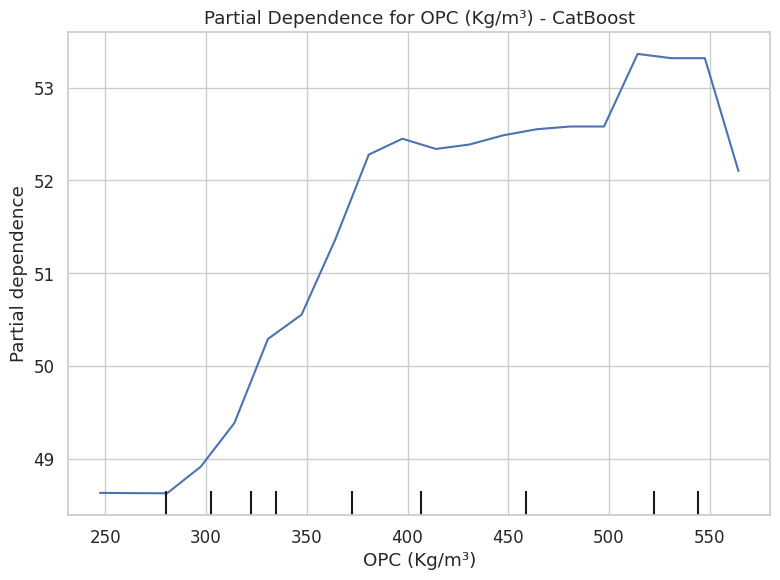

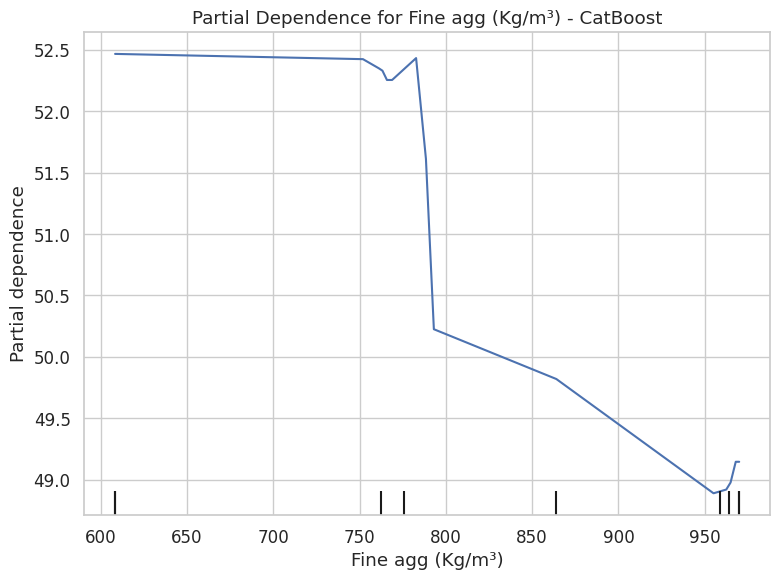

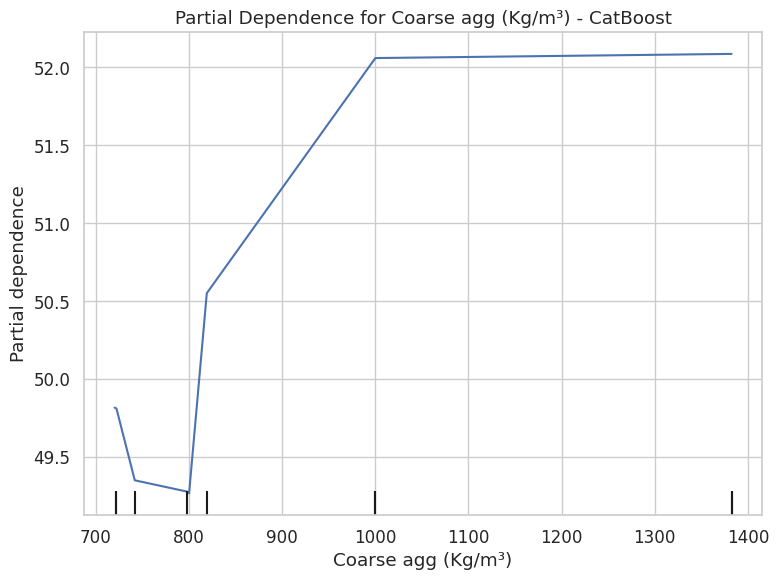

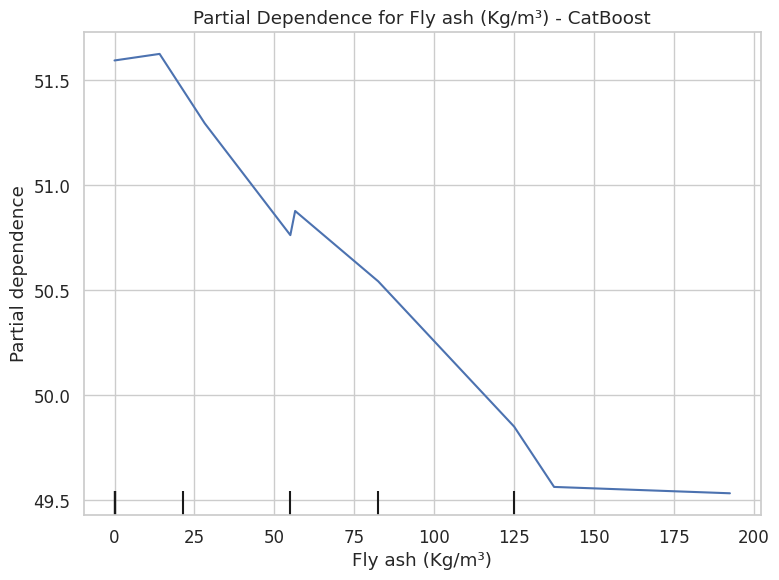

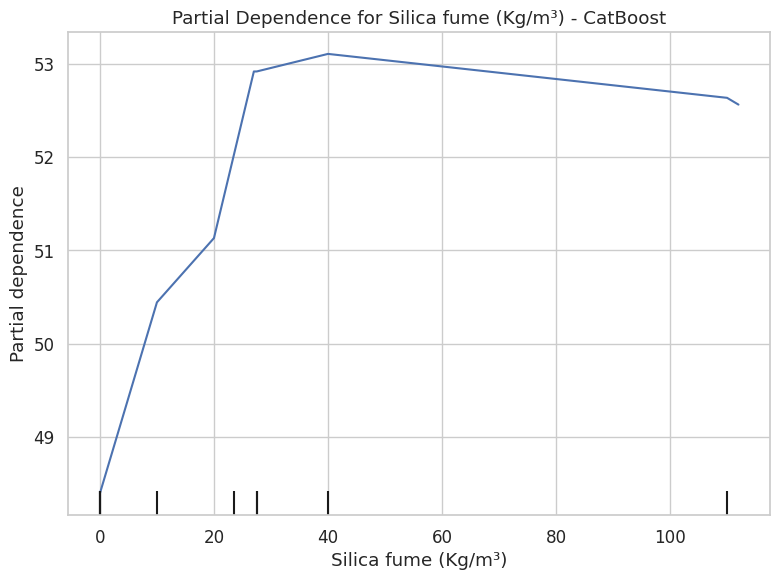

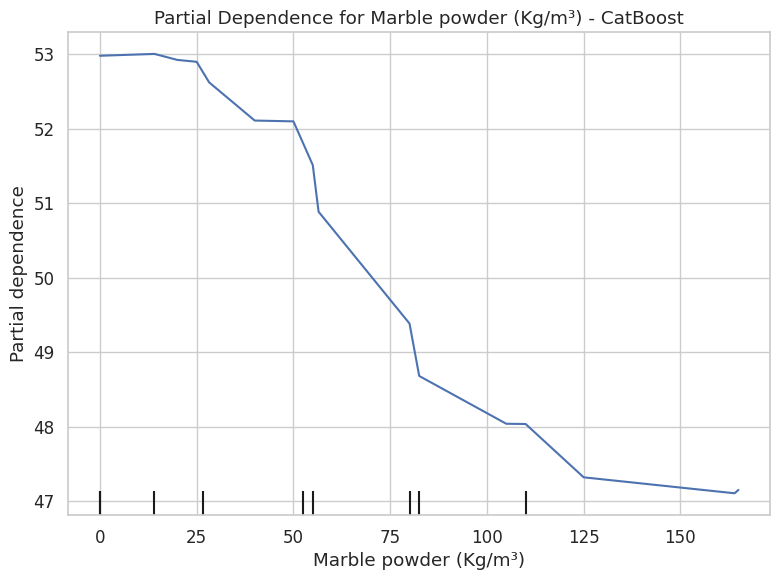

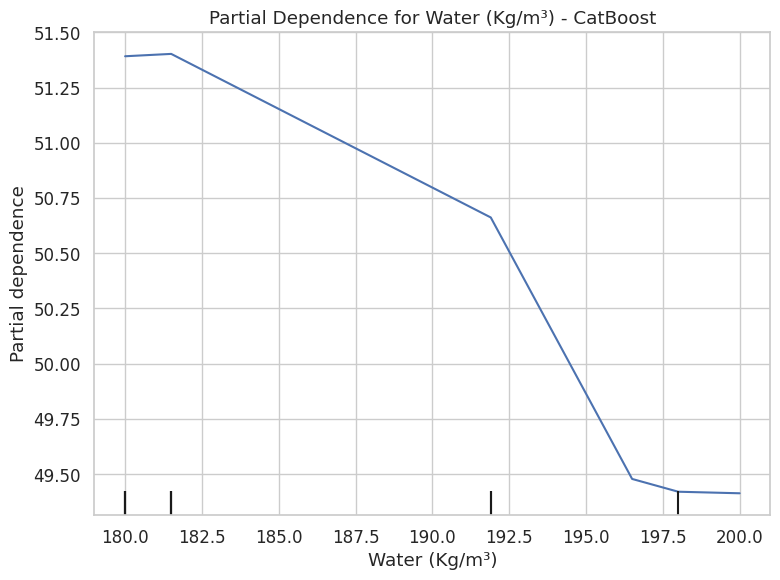

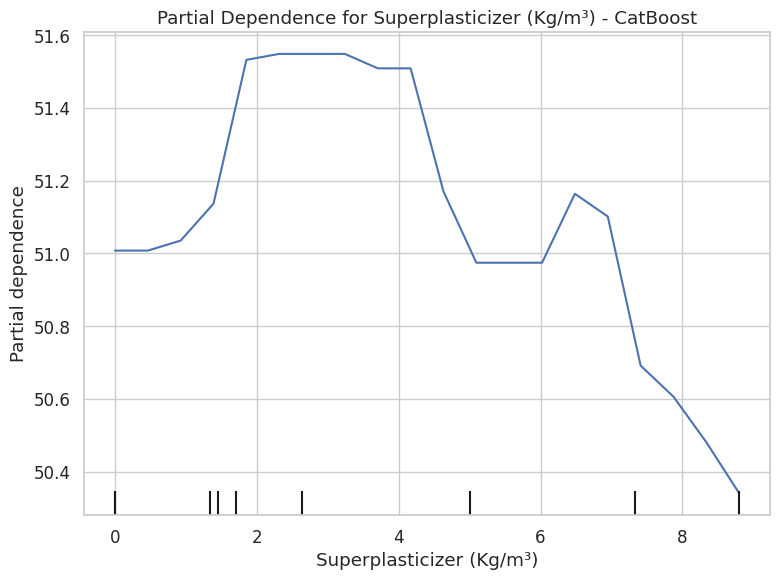

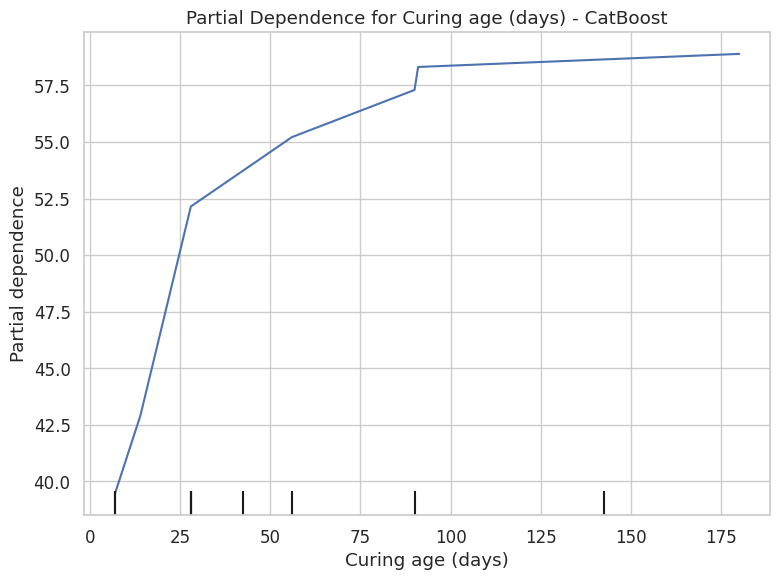

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import time

# List of feature names
features = [
    'OPC (Kg/m³)', 'Fine agg (Kg/m³)', 'Coarse agg (Kg/m³)',
    'Fly ash (Kg/m³)', 'Silica fume (Kg/m³)', 'Marble powder (Kg/m³)',
    'Water (Kg/m³)', 'Superplasticizer (Kg/m³)', 'Curing age (days)'
]

# Use only selected features for X_test
X_test_selected = X_test[features]

# Standard models
standard_models = {
    # "Random Forest": results["Random Forest"]["Best Model"],
    "Gradient Boosting": results["Gradient Boosting"]["Best Model"],
    # "AdaBoost": results["AdaBoost"]["Best Model"],
    "XGBoost": results["XGBoost"]["Best Model"],
    "LightGBM": results["LightGBM"]["Best Model"],
    "CatBoost": results["CatBoost"]["Best Model"]
}

# Plot with visual separation
for model_name, model in standard_models.items():
    for feature in features:
        feature_idx = X.columns.get_loc(feature)
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(
            estimator=model,
            X=X_test_selected,
            features=[feature_idx],
            grid_resolution=20,
            ax=ax
        )
        ax.set_title(f"Partial Dependence for {feature} - {model_name}")
        plt.tight_layout()
        plt.show()

        # Add a slight pause and a visual print to separate plots
        print("\n" + "="*80 + "\n")
        time.sleep(0.5)  # Optional: slow down rendering slightly for clarity

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.inspection import PartialDependenceDisplay
# from matplotlib.backends.backend_pdf import PdfPages
# from google.colab import files
# import time

# # Feature names
# features = [
#     'OPC (Kg/m³)', 'Fine agg (Kg/m³)', 'Coarse agg (Kg/m³)',
#     'Fly ash (Kg/m³)', 'Silica fume (Kg/m³)', 'Marble powder (Kg/m³)',
#     'Water (Kg/m³)', 'Superplasticizer (Kg/m³)', 'Curing age (days)'
# ]

# # Subset of test data
# X_test_selected = X_test[features]

# # Models to plot
# standard_models = {
#     "Gradient Boosting": results["Gradient Boosting"]["Best Model"],
#     "XGBoost": results["XGBoost"]["Best Model"],
#     "LightGBM": results["LightGBM"]["Best Model"],
#     "CatBoost": results["CatBoost"]["Best Model"]
# }

# # Output PDF file name
# pdf_filename = "partial_dependence_plots.pdf"

# with PdfPages(pdf_filename) as pdf:
#     for model_name, model in standard_models.items():
#         for feature in features:
#             feature_idx = X.columns.get_loc(feature)

#             fig, ax = plt.subplots(figsize=(8, 6))
#             PartialDependenceDisplay.from_estimator(
#                 estimator=model,
#                 X=X_test_selected,
#                 features=[feature_idx],
#                 grid_resolution=20,
#                 ax=ax
#             )

#             # Style
#             ax.set_title(f"Partial Dependence for {feature} - {model_name}", color='black')
#             ax.set_xlabel(ax.get_xlabel(), color='black')
#             ax.set_ylabel(ax.get_ylabel(), color='black')
#             ax.tick_params(colors='black')

#             # Black border
#             for spine in ax.spines.values():
#                 spine.set_edgecolor('black')
#                 spine.set_linewidth(1.2)

#             plt.tight_layout()
#             pdf.savefig(fig)
#             plt.close(fig)
#             print(f"Saved plot: {feature} - {model_name}")
#             time.sleep(0.1)

# # Download the final PDF
# files.download(pdf_filename)


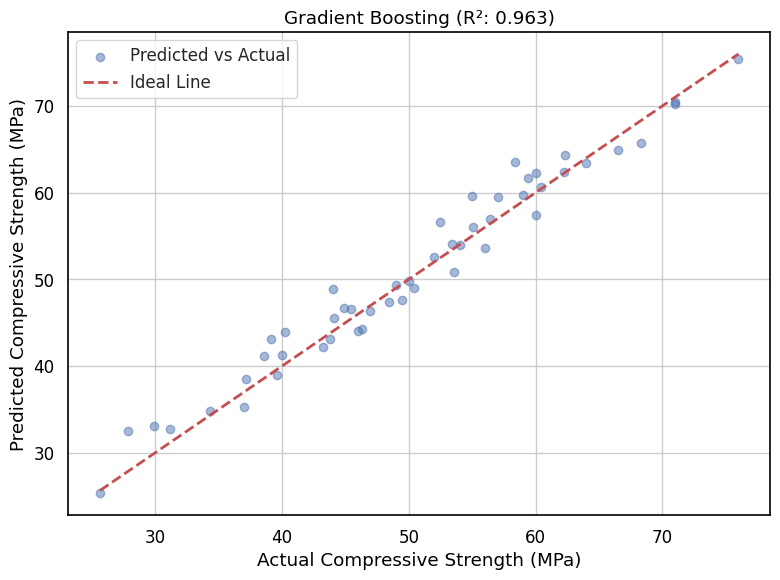

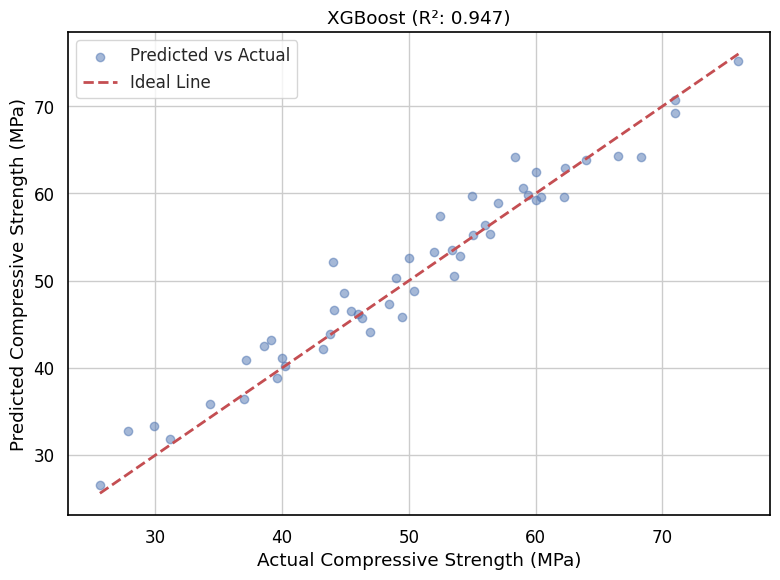



[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


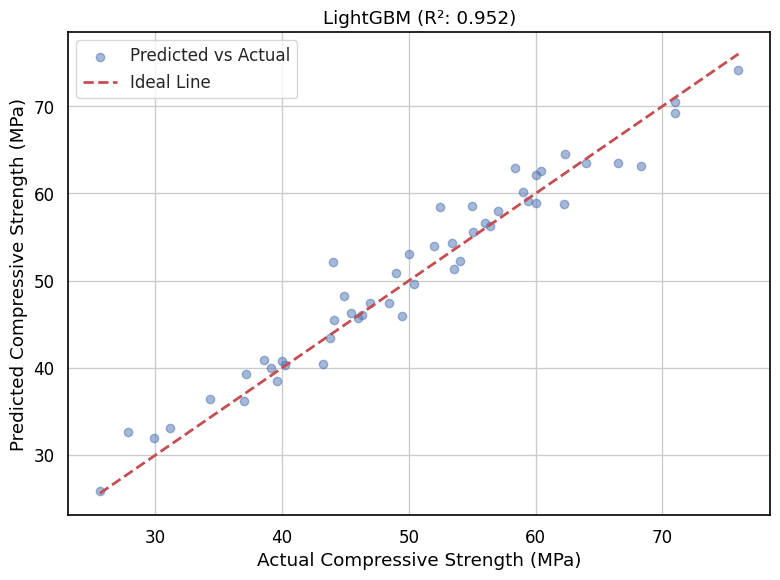

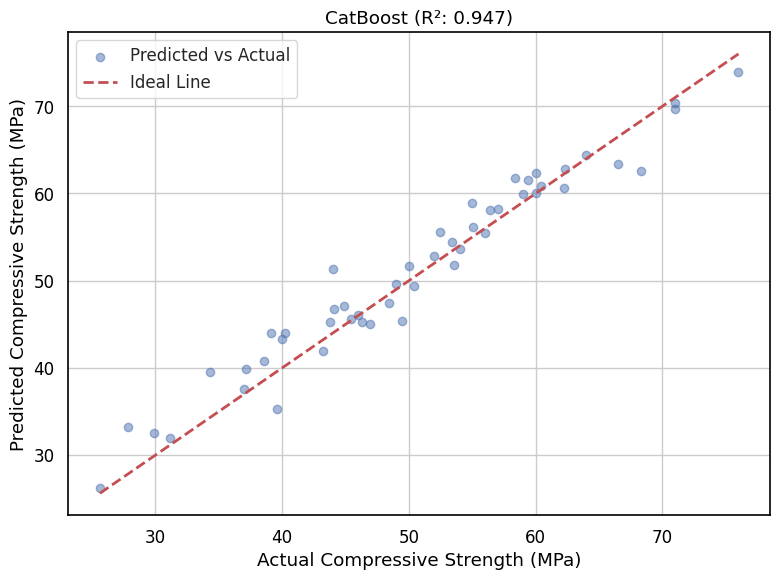

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(X_test, y_test, results):
    for model_name in results:
        best_model = results[model_name]['Best Model']

        # Handle Hybrid model (XGB-LGB) separately
        if model_name == "Hybrid XGB-LGB":
            xgb_best_model = results["XGBoost"]["Best Model"]
            xgb_pred_test = xgb_best_model.predict(X_test).reshape(-1, 1)
            y_pred = best_model.predict(xgb_pred_test)
        else:
            y_pred = best_model.predict(X_test)

        # Create a new figure for each model
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
        plt.xlabel('Actual Compressive Strength (MPa)', color='black')
        plt.ylabel('Predicted Compressive Strength (MPa)', color='black')
        plt.title(f'{model_name} (R²: {results[model_name]["R² Score"]:.3f})', color='black')
        plt.legend()
        plt.grid(True)
        plt.tick_params(colors='black')  # make axis ticks black

        # Make plot border black
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

        plt.tight_layout()
        plt.show()

        print("\n" + "="*80 + "\n")

# Call the function
plot_actual_vs_predicted(X_test, y_test, results)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.backends.backend_pdf import PdfPages
# from google.colab import files  # Only needed in Colab

# def plot_actual_vs_predicted_pdf(X_test, y_test, results, pdf_filename='actual_vs_predicted_plots.pdf'):
#     with PdfPages(pdf_filename) as pdf:
#         for model_name in results:
#             best_model = results[model_name]['Best Model']

#             if model_name == "Hybrid XGB-LGB":
#                 xgb_best_model = results["XGBoost"]["Best Model"]
#                 xgb_pred_test = xgb_best_model.predict(X_test).reshape(-1, 1)
#                 y_pred = best_model.predict(xgb_pred_test)
#             else:
#                 y_pred = best_model.predict(X_test)

#             fig, ax = plt.subplots(figsize=(8, 6))
#             ax.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
#             ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
#             ax.set_xlabel('Actual Compressive Strength (MPa)')
#             ax.set_ylabel('Predicted Compressive Strength (MPa)')
#             ax.set_title(f'{model_name} (R²: {results[model_name]["R² Score"]:.3f})')
#             ax.legend()
#             ax.grid(True)
#             plt.tight_layout()
#             pdf.savefig(fig)
#             plt.close(fig)

#             print(f"Added {model_name} plot to PDF.")

#     # Download the PDF
#     files.download(pdf_filename)

# # Call the function in Colab
# plot_actual_vs_predicted_pdf(X_test, y_test, results)


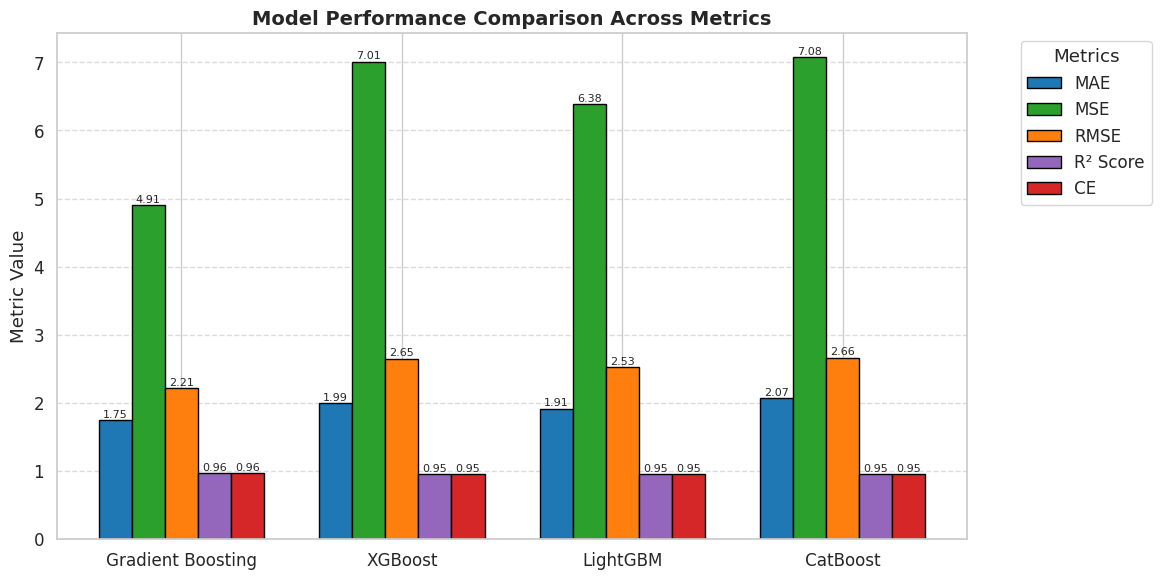

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(14, 6))
metrics = ['MAE', 'MSE', 'RMSE', 'R² Score', 'CE']
n_models = len(results_df)
x = np.arange(n_models)
width = 0.15

# Custom polished colors
colors = [
    '#1f77b4',  # Deep Blue (MAE)
    '#2ca02c',  # Teal (MSE)
    '#ff7f0e',  # Golden Orange (RMSE)
    '#9467bd',  # Purple (R2 Score)
    '#d62728'   # Crimson Red (CE)
]

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(x + (i - 2) * width, results_df[metric], width, label=metric, color=color, edgecolor='black')

for i in range(n_models):
    for j, metric in enumerate(metrics):
        value = results_df[metric].iloc[i]
        plt.text(x[i] + (j - 2) * width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, results_df.index, rotation=0, ha='center')
plt.ylabel('Metric Value')
plt.title('Model Performance Comparison Across Metrics', fontsize=14, weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from google.colab import files  # Only for Colab

# sns.set(style="whitegrid", font_scale=1.1)

# # Create the plot
# plt.figure(figsize=(14, 6))
# metrics = ['MAE', 'MSE', 'RMSE', 'R² Score', 'CE']
# n_models = len(results_df)
# x = np.arange(n_models)
# width = 0.15

# # Custom polished colors
# colors = [
#     '#1f77b4',  # Deep Blue (MAE)
#     '#2ca02c',  # Teal (MSE)
#     '#ff7f0e',  # Golden Orange (RMSE)
#     '#9467bd',  # Purple (R² Score)
#     '#d62728'   # Crimson Red (CE)
# ]

# # Plotting bars
# for i, (metric, color) in enumerate(zip(metrics, colors)):
#     plt.bar(x + (i - 2) * width, results_df[metric], width, label=metric, color=color, edgecolor='black')

# # Annotate values
# for i in range(n_models):
#     for j, metric in enumerate(metrics):
#         value = results_df[metric].iloc[i]
#         plt.text(x[i] + (j - 2) * width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

# # Labels and formatting
# plt.xticks(x, results_df.index, rotation=0, ha='center')
# plt.ylabel('Metric Value')
# plt.title('Model Performance Comparison Across Metrics', fontsize=14, weight='bold')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Metrics")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout(rect=[0, 0, 0.85, 1])

# # Save as PDF
# pdf_filename = "model_performance_comparison.pdf"
# plt.savefig(pdf_filename, bbox_inches='tight')

# # Download the PDF
# files.download(pdf_filename)

# # Optional: also show it in Colab
# plt.show()


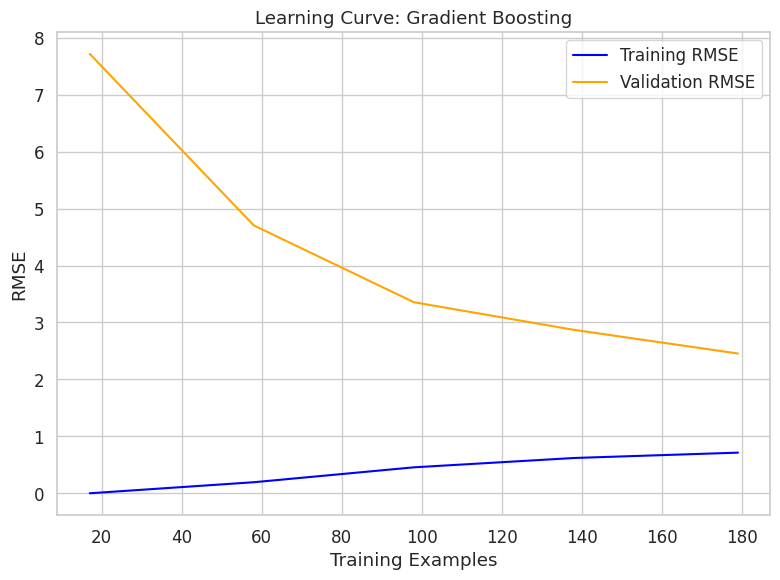

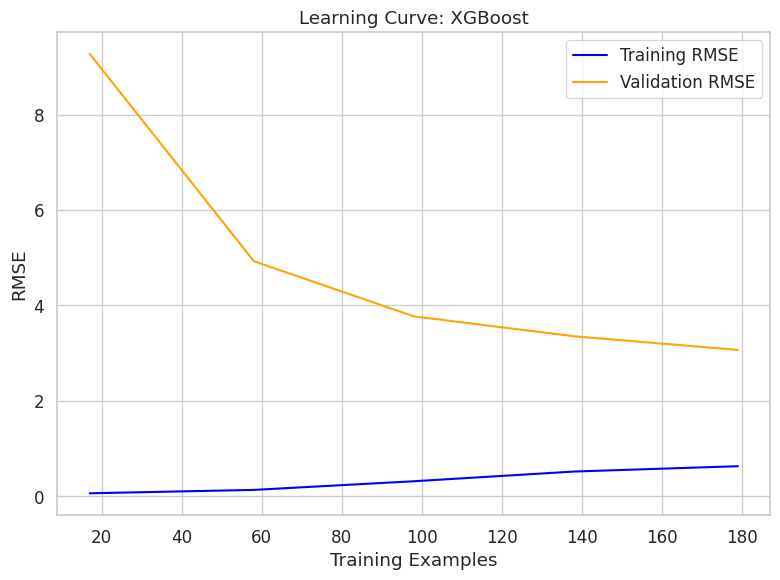

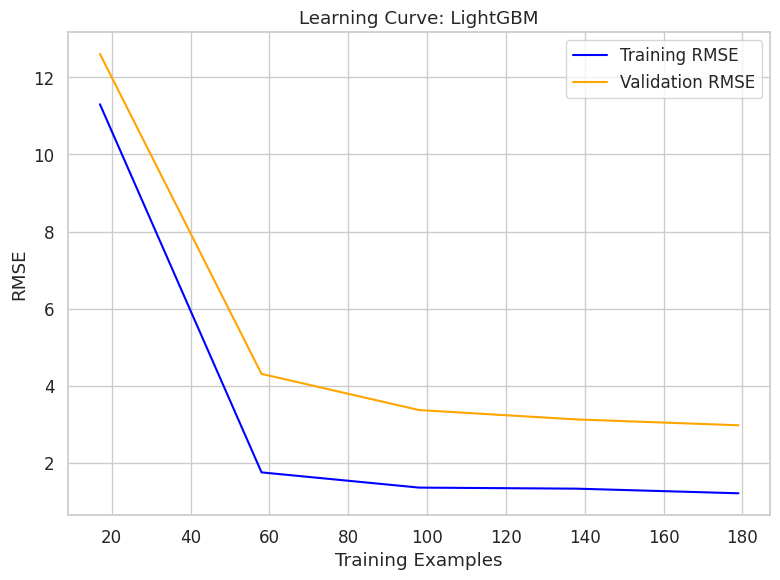

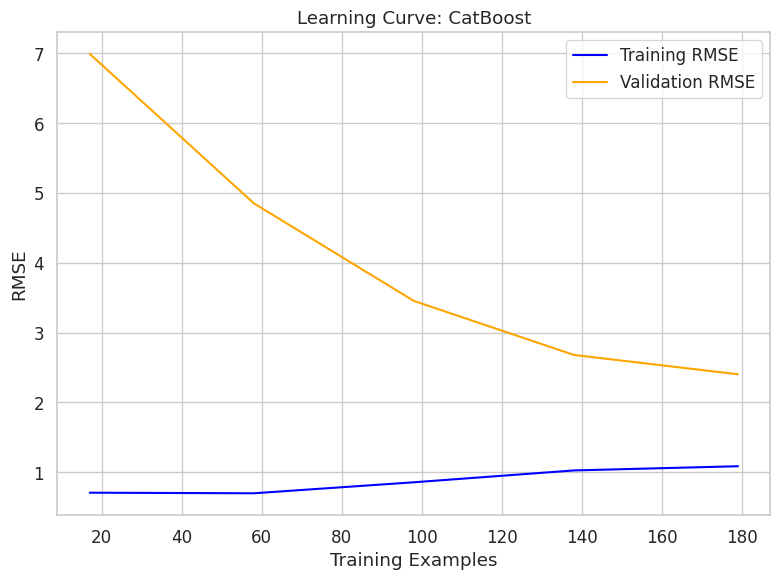

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curves_separately(results, results_df, X_train, y_train):
    for model_name in results_df.index:
        model = results[model_name]['Best Model']

        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=10,
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
        val_scores_mean = np.sqrt(-val_scores.mean(axis=1))

        # Create a new plot for each model
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, label='Training RMSE', color='blue')
        plt.plot(train_sizes, val_scores_mean, label='Validation RMSE', color='orange')
        plt.title(f'Learning Curve: {model_name}')
        plt.xlabel('Training Examples')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Optional terminal split
        print("\n" + "="*80 + "\n")

# Call the function
plot_learning_curves_separately(results, results_df, X_train, y_train)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.model_selection import learning_curve
# from matplotlib.backends.backend_pdf import PdfPages
# from google.colab import files  # Colab-specific

# def plot_learning_curves_to_pdf(results, results_df, X_train, y_train, pdf_path='learning_curves.pdf'):
#     with PdfPages(pdf_path) as pdf:
#         for model_name in results_df.index:
#             model = results[model_name]['Best Model']

#             train_sizes, train_scores, val_scores = learning_curve(
#                 model, X_train, y_train, cv=10,
#                 scoring='neg_mean_squared_error', n_jobs=-1
#             )
#             train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
#             val_scores_mean = np.sqrt(-val_scores.mean(axis=1))

#             fig, ax = plt.subplots(figsize=(8, 6))
#             ax.plot(train_sizes, train_scores_mean, label='Training RMSE', color='blue')
#             ax.plot(train_sizes, val_scores_mean, label='Validation RMSE', color='orange')
#             ax.set_title(f'Learning Curve: {model_name}')
#             ax.set_xlabel('Training Examples')
#             ax.set_ylabel('RMSE')
#             ax.grid(True)
#             ax.legend()
#             plt.tight_layout()

#             pdf.savefig(fig)
#             plt.close(fig)

#             print(f"Saved learning curve for {model_name} to PDF.")

#     # Trigger file download to your PC
#     files.download(pdf_path)

# # Call this function in Colab
# plot_learning_curves_to_pdf(results, results_df, X_train, y_train)
